<a href="https://colab.research.google.com/github/alihussainia/Crypto-Portfolio_Optimization/blob/main/DTF1_portfolio_strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install PyPortfolioOpt

In [3]:
# import packages
import pandas as pd
import numpy as np
import csv
import random
from scipy import optimize
import requests
import os
from matplotlib import pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter
from pypfopt import HRPOpt
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
%cd "%cd /content/drive/MyDrive/Final/data"

/content/drive/MyDrive/Final/data/Bitstamp


In [16]:
# select exchange - Bitstamp
exchange = input('Please select the crypto exchange: ')

Please select the crypto exchange: Bitstamp


In [151]:
# select cryptocurrency - SOLUSDT (start in 2020) - MATICUSDT (died in 09 09 24) # 'SOLUSDT' 'MATICUSDT'
"""
['BTCUSD', 'ETHUSD', 'XRPUSD', 'ADAUSD', 'DOGEUSD', 'DOTUSD', 'LTCUSD', 'SOLUSD']
"""
cryptos = []
crypto = "d"
while crypto!='q':
  try:
    crypto = input('Please enter the cryptocurrency code or press q to quit: ')
    if crypto != 'q':
      cryptos.append(crypto)
  except crypto=="":
    print("Please enter the cryptocurrency code")
print(f"Your selected cryptos: {cryptos}")

Please enter the cryptocurrency code or press q to quit: BTCUSD
Please enter the cryptocurrency code or press q to quit: ETHUSD
Please enter the cryptocurrency code or press q to quit: XRPUSD
Please enter the cryptocurrency code or press q to quit: ADAUSD
Please enter the cryptocurrency code or press q to quit: DOGEUSD
Please enter the cryptocurrency code or press q to quit: DOTUSD
Please enter the cryptocurrency code or press q to quit: LTCUSD
Please enter the cryptocurrency code or press q to quit: SOLUSD
Please enter the cryptocurrency code or press q to quit: q
Your selected cryptos: ['BTCUSD', 'ETHUSD', 'XRPUSD', 'ADAUSD', 'DOGEUSD', 'DOTUSD', 'LTCUSD', 'SOLUSD']


In [49]:
# cryptos=['BTCUSD', 'ETHUSD', 'XRPUSD', 'ADAUSD', 'DOGEUSD', 'DOTUSD', 'LTCUSD', 'SOLUSD']

# Data Collection and Analysis

In this notebook, we'll use one way to scrap some cryptocurrency data from the internet. It is not the only way you can obtain data, and probabily not the best one. But it is a good application of the things seen in class.

We are using API data from cryptodatadownload.com

After creating our database, we will take a first analysis of our time series with plots and summary statistics.

### Data collection
In the code below, we select the frequency, the exchange, and the code of the cryptocurrency that we select. The code in the data collection part must be run multiple times, one for every frequency, exchange and cryptocurrency code. We could download everything that we need in one run by creating a list of values for each of the three attributes and using loops.

## Daily Data collection and time series analysis


In [183]:
# select frequency
freq_ok = 0
while freq_ok == 0:
    freq_in = input('Please select frequency (daily/hourly): ')
    if freq_in == 'daily':
        freq = 'd'
        freq_ok = 1
    elif freq_in == 'hourly':
        freq = '1h'
        freq_ok = 1
    else:
        print("Incorrect input")

Please select frequency (daily/hourly): daily


In [184]:
# create paths a.k.a create relevant folders
exchange_path = os.getcwd() + '/' + exchange
if not os.path.exists(exchange_path):
    os.mkdir(exchange_path)
output_path = exchange_path + '/' + freq_in
if not os.path.exists(output_path):
    os.mkdir(output_path)

In [185]:
# creating empty files for each crypto
for crypto in cryptos:
    file_path = output_path + '/' + crypto + '.csv'

    try:
      with open(file_path, "w") as f:
          print(f"File created successfully at {file_path}")
    except FileExistsError:
            print(f"File already exists at {file_path}")

File created successfully at /content/drive/MyDrive/Final/data/Bitstamp/daily/BTCUSD.csv
File created successfully at /content/drive/MyDrive/Final/data/Bitstamp/daily/ETHUSD.csv
File created successfully at /content/drive/MyDrive/Final/data/Bitstamp/daily/XRPUSD.csv
File created successfully at /content/drive/MyDrive/Final/data/Bitstamp/daily/ADAUSD.csv
File created successfully at /content/drive/MyDrive/Final/data/Bitstamp/daily/DOGEUSD.csv
File created successfully at /content/drive/MyDrive/Final/data/Bitstamp/daily/DOTUSD.csv
File created successfully at /content/drive/MyDrive/Final/data/Bitstamp/daily/LTCUSD.csv
File created successfully at /content/drive/MyDrive/Final/data/Bitstamp/daily/SOLUSD.csv


In [186]:
for crypto in cryptos:
    url = 'https://www.cryptodatadownload.com/cdd/' + exchange + '_' + crypto + '_' + freq + '.csv'
    print(url)
    # download from API with the requests module
    response = requests.get(url)

    # save data in csv file
    if response.status_code == 200:
        # Decode the content
        decoded_content = response.content.decode('utf-8')

        # Split the content into lines
        csv_lines = decoded_content.splitlines()

        # Use the csv module to write to a file
        with open(f'{output_path}/{crypto}.csv', mode='w', newline='', encoding='utf-8') as file:
            writer = csv.writer(file)
            for line in csv.reader(csv_lines[1:]):
                writer.writerow(line)

        print(f"CSV file saved as {crypto}.csv")

https://www.cryptodatadownload.com/cdd/Bitstamp_BTCUSD_d.csv
CSV file saved as BTCUSD.csv
https://www.cryptodatadownload.com/cdd/Bitstamp_ETHUSD_d.csv
CSV file saved as ETHUSD.csv
https://www.cryptodatadownload.com/cdd/Bitstamp_XRPUSD_d.csv
CSV file saved as XRPUSD.csv
https://www.cryptodatadownload.com/cdd/Bitstamp_ADAUSD_d.csv
CSV file saved as ADAUSD.csv
https://www.cryptodatadownload.com/cdd/Bitstamp_DOGEUSD_d.csv
CSV file saved as DOGEUSD.csv
https://www.cryptodatadownload.com/cdd/Bitstamp_DOTUSD_d.csv
CSV file saved as DOTUSD.csv
https://www.cryptodatadownload.com/cdd/Bitstamp_LTCUSD_d.csv
CSV file saved as LTCUSD.csv
https://www.cryptodatadownload.com/cdd/Bitstamp_SOLUSD_d.csv
CSV file saved as SOLUSD.csv


### Database creation
In the code below, we select the frequency and the exchange. Then we create a database with all the prices of the cryptocurrencies we downloaded with that specific frequency and exchange.

In [187]:
# load files
path = exchange_path + '/' + freq_in + '/'
file_names = [f for f in os.listdir(path) if not f.startswith('.')]

dataframes = {}
for file_name in file_names:
    name = file_name.split('/')[-1].split('.')[0]
    dataframes[name] = pd.read_csv(path+file_name)

We now identify the common columns for all the different cryptocurrencies to create a database for each attribute that collects values for every cryptocurrency.

In [188]:
# identifying common columns
common_columns = set.intersection(*[set(df.columns) for df in dataframes.values()])
common_columns.remove('unix')
common_columns.remove('symbol')
common_columns.remove('date')

In [189]:
# create combined dataframes for each attribute
for column in common_columns:
    combined_df = pd.DataFrame()
    for name, df in dataframes.items():
        # Select relevant columns
        temp_df = df[['date', column]].copy()
        temp_df.rename(columns={column: name}, inplace=True)  # Rename column to the dataset's name
        combined_df = combined_df.merge(temp_df, on='date', how='outer') if not combined_df.empty else temp_df

    # Saving the combined DataFrame as a CSV file
    combined_df.to_csv(f'{exchange_path}' + f'/{freq}_{column}.csv', index=False)

In [190]:
combined_df.dropna(inplace=True)
combined_df.head()

,date,ADAUSD,XRPUSD,SOLUSD,BTCUSD,LTCUSD,ETHUSD,DOTUSD,DOGEUSD
2945,2022-12-21 00:00:00,159982.828777,4.098566e+07,48714.720264,2.723414e+07,544059.264888,8.554885e+06,42290.84160,5.131000
2946,2022-12-22 00:00:00,157617.058093,3.465169e+07,27463.997548,3.273880e+07,408261.213788,9.756090e+06,126217.21247,6279.075571
2947,2022-12-23 00:00:00,409710.271823,2.916665e+07,41829.728180,3.588100e+07,417443.039719,4.747786e+06,49033.51475,21459.144402
2948,2022-12-24 00:00:00,49793.916931,2.437447e+06,65155.374496,1.617094e+07,293108.357244,2.000353e+06,21883.31628,1735.170817
2949,2022-12-25 00:00:00,39891.241284,4.525486e+06,33306.954658,1.208192e+07,713775.481269,3.117663e+06,9263.52196,20975.559393


### Time series analysis
We now load only the closing prices and try to understand how each time series behaves and is distributed.

In [191]:
# load data
path = exchange_path + '/'
file_name = path + freq + '_close.csv'
daily_data = pd.read_csv(file_name)

daily_data["date"] = pd.to_datetime(daily_data["date"])
daily_data.set_index('date', inplace=True)
daily_data.sort_values(by='date', ascending=True, inplace=True)
daily_data.drop(daily_data.tail(1).index,inplace=True)

In [192]:
daily_data.dropna(inplace=True)

In [193]:
daily_data = daily_data[daily_data.index >= '2022-12-22']
daily_data = daily_data[daily_data.index < '2024-12-02']
daily_data.head()

,ADAUSD,XRPUSD,SOLUSD,BTCUSD,LTCUSD,ETHUSD,DOTUSD,DOGEUSD
date,,,,,,,,
2022-12-22,0.25625,0.34961,11.7364,16821.0,66.15,1218.0,4.531,0.07739
2022-12-23,0.25938,0.35452,11.7805,16779.0,65.78,1220.3,4.475,0.07691
2022-12-24,0.25872,0.35203,11.3959,16839.0,65.76,1220.5,4.452,0.07783
2022-12-25,0.25918,0.34558,11.3882,16828.0,69.14,1218.1,4.469,0.07631
2022-12-26,0.26332,0.36613,11.3287,16917.0,70.60,1227.7,4.574,0.07481


In [194]:
# number of assets
N_assets_tot = daily_data.shape[1]

### Plot the data
One of the best ways to understand the behaviour of data is plotting and visualizing.

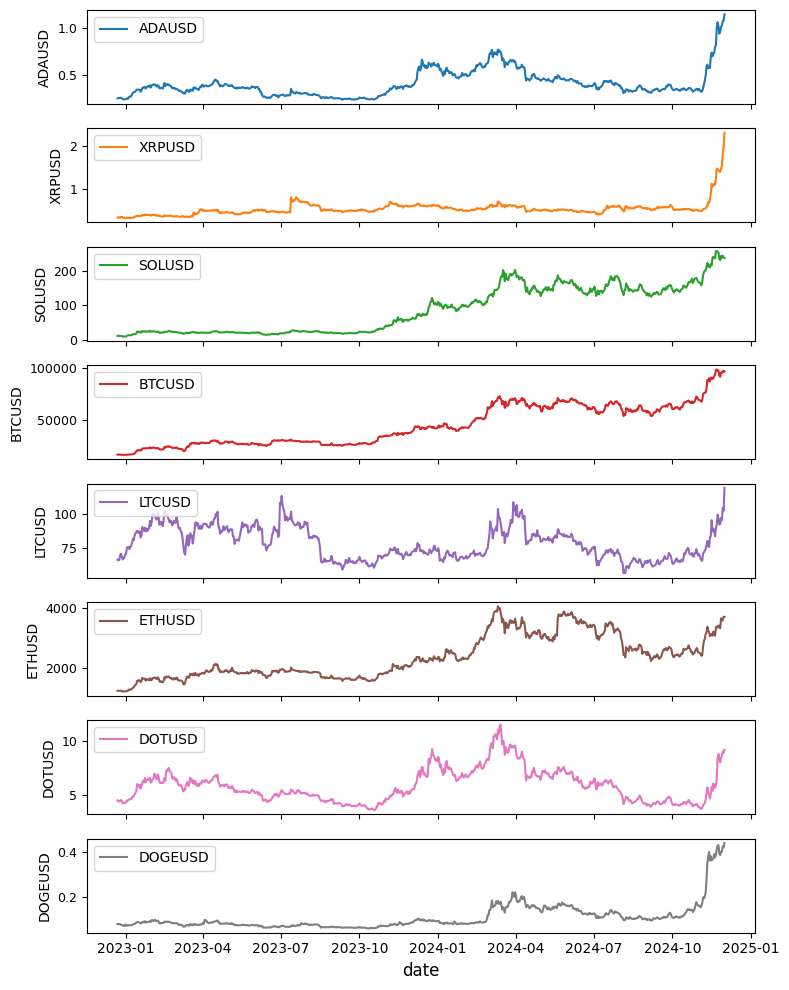

In [195]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define a color palette
colors = sns.color_palette("tab10", len(daily_data.columns))

# Plot the data
fig, axes = plt.subplots(len(daily_data.columns), 1, figsize=(8, 10), sharex=True)

for i, column in enumerate(daily_data.columns):
    axes[i].plot(daily_data.index, daily_data[column], color=colors[i], label=column, linewidth=1.5)
    axes[i].legend(loc="upper left", fontsize=10)
    axes[i].set_ylabel(column, fontsize=10)
    axes[i].tick_params(axis="y", labelsize=9)

axes[-1].set_xlabel("date", fontsize=12)
plt.tight_layout()
plt.show()

### Summary statistics
Summary statistics give us a better idea of the distribution of our data. Useful statistics are:
- **Mean**. The mean of a dataset is the sum of all values divided by the total number of values. It’s the most commonly used measure of central tendency and is often referred to as the “average.”
- **Standard deviation**. The standard deviation is the average amount of variability in your dataset. It tells you, on average, how far each value lies from the mean. A high standard deviation means that values are generally far from the mean, while a low standard deviation indicates that values are clustered close to the mean.
- **Minimum**. The minimum value of a dataset.
- **Median**. The median is the value that’s exactly in the middle of a dataset when it is ordered. It’s a measure of central tendency that separates the lowest 50% from the highest 50% of values. It is also known as the 50% percentile.
- **Maximum**.The maximum value of a dataset.
- **Variance**. The variance is a measure of variability. It is calculated by taking the average of squared deviations from the mean. Variance tells you the degree of spread in your data set. The more spread the data, the larger the variance is in relation to the mean.
- **Skewness**. Skewness is a measure of the asymmetry of a distribution. A positively skewed distribution is longer on the right side of its peak, and a negatively skewed distribution is longer on the left side of its peak.
- **Kurtosis**. Kurtosis is a measure of the tailedness of a distribution, or how often outliers occur. Distributions with low kurtosis have thin tails, while distributions with high kurtosis have fat tails.
- ...

In [196]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

stats = daily_data.describe()
stats.loc['var'] = daily_data.var().tolist()
stats.loc['skew'] = daily_data.skew().tolist()
stats.loc['kurt'] = daily_data.kurtosis().tolist()

stats

,ADAUSD,XRPUSD,SOLUSD,BTCUSD,LTCUSD,ETHUSD,DOTUSD,DOGEUSD
count,711.000000,711.000000,711.000000,7.110000e+02,711.000000,711.000000,711.000000,711.000000
mean,0.411179,0.549246,86.330140,4.485977e+04,78.313010,2352.410408,5.895940,0.107650
std,0.140939,0.167837,66.761935,1.949460e+04,11.924132,714.646194,1.519807,0.061564
min,0.241210,0.337890,9.662400,1.652800e+04,55.990000,1189.500000,3.637000,0.057750
25%,0.325245,0.483080,21.792300,2.742600e+04,68.410000,1793.600000,4.609500,0.073235
50%,0.376340,0.524740,72.240000,4.156000e+04,75.600000,2222.800000,5.667000,0.085760
75%,0.459315,0.596675,144.907900,6.315050e+04,88.280000,2969.000000,6.767500,0.123865
max,1.148960,2.296720,256.964700,9.901300e+04,119.660000,4066.500000,11.563000,0.441240
var,0.019864,0.028169,4457.156002,3.800394e+08,142.184926,510719.181948,2.309812,0.003790
skew,1.763701,4.866815,0.401444,4.719608e-01,0.428221,0.554997,0.900316,3.166677


### Returns
When we construct portfolios, we are more interested in the differences in prices than levels, as we want to focus on how much we can make. Moreover, thinking in differences makes all the series comparable.

In [197]:
# compute returns
daily_returns = daily_data.pct_change()[1:]

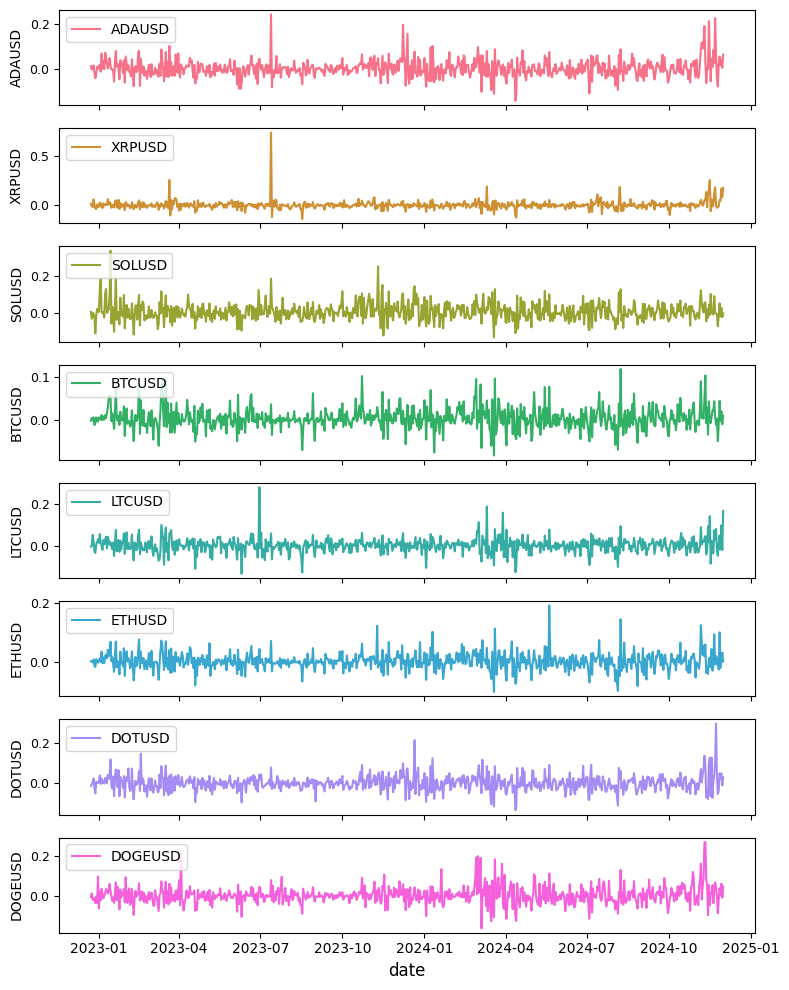

In [199]:
# Define a color palette for returns plot
return_colors = sns.color_palette("husl", len(daily_returns.columns))

# Plot the returns
fig, axes = plt.subplots(len(daily_returns.columns), 1, figsize=(8, 10), sharex=True)

for i, column in enumerate(daily_returns.columns):
    axes[i].plot(daily_returns.index, daily_returns[column], color=return_colors[i], label=column, linewidth=1.5)
    axes[i].legend(loc="upper left", fontsize=10)
    axes[i].set_ylabel(column, fontsize=10)
    axes[i].tick_params(axis="y", labelsize=9)

axes[-1].set_xlabel("date", fontsize=12)
plt.tight_layout()
plt.show()


In [200]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

stats_ret = daily_returns.describe()
stats_ret.loc['var'] = daily_returns.var().tolist()
stats_ret.loc['skew'] = daily_returns.skew().tolist()
stats_ret.loc['kurt'] = daily_returns.kurtosis().tolist()

stats

,ADAUSD,XRPUSD,SOLUSD,BTCUSD,LTCUSD,ETHUSD,DOTUSD,DOGEUSD
count,711.000000,711.000000,711.000000,7.110000e+02,711.000000,711.000000,711.000000,711.000000
mean,0.411179,0.549246,86.330140,4.485977e+04,78.313010,2352.410408,5.895940,0.107650
std,0.140939,0.167837,66.761935,1.949460e+04,11.924132,714.646194,1.519807,0.061564
min,0.241210,0.337890,9.662400,1.652800e+04,55.990000,1189.500000,3.637000,0.057750
25%,0.325245,0.483080,21.792300,2.742600e+04,68.410000,1793.600000,4.609500,0.073235
50%,0.376340,0.524740,72.240000,4.156000e+04,75.600000,2222.800000,5.667000,0.085760
75%,0.459315,0.596675,144.907900,6.315050e+04,88.280000,2969.000000,6.767500,0.123865
max,1.148960,2.296720,256.964700,9.901300e+04,119.660000,4066.500000,11.563000,0.441240
var,0.019864,0.028169,4457.156002,3.800394e+08,142.184926,510719.181948,2.309812,0.003790
skew,1.763701,4.866815,0.401444,4.719608e-01,0.428221,0.554997,0.900316,3.166677


## Hourly Data Collection and Analysis

### Data collection

In [201]:
# select hourly frequency
freq_ok = 0
while freq_ok == 0:
    freq_in = input('Please select frequency (daily/hourly): ')
    if freq_in == 'daily':
        freq = 'd'
        freq_ok = 1
    elif freq_in == 'hourly':
        freq = '1h'
        freq_ok = 1
    else:
        print("Incorrect input")

Please select frequency (daily/hourly): hourly


In [202]:
# create paths a.k.a create relevant folders
exchange_path = os.getcwd() + '/' + exchange
if not os.path.exists(exchange_path):
    os.mkdir(exchange_path)
output_path = exchange_path + '/' + freq_in
if not os.path.exists(output_path):
    os.mkdir(output_path)

In [203]:
# creating empty files for each crypto
for crypto in cryptos:
    file_path = output_path + '/' + crypto + '.csv'

    try:
      with open(file_path, "w") as f:
          print(f"File created successfully at {file_path}")
    except FileExistsError:
            print(f"File already exists at {file_path}")

File created successfully at /content/drive/MyDrive/Final/data/Bitstamp/hourly/BTCUSD.csv
File created successfully at /content/drive/MyDrive/Final/data/Bitstamp/hourly/ETHUSD.csv
File created successfully at /content/drive/MyDrive/Final/data/Bitstamp/hourly/XRPUSD.csv
File created successfully at /content/drive/MyDrive/Final/data/Bitstamp/hourly/ADAUSD.csv
File created successfully at /content/drive/MyDrive/Final/data/Bitstamp/hourly/DOGEUSD.csv
File created successfully at /content/drive/MyDrive/Final/data/Bitstamp/hourly/DOTUSD.csv
File created successfully at /content/drive/MyDrive/Final/data/Bitstamp/hourly/LTCUSD.csv
File created successfully at /content/drive/MyDrive/Final/data/Bitstamp/hourly/SOLUSD.csv


In [204]:
for crypto in cryptos:
    url = 'https://www.cryptodatadownload.com/cdd/' + exchange + '_' + crypto + '_' + freq + '.csv'
    print(url)
    # download from API with the requests module
    response = requests.get(url)

    # save data in csv file
    if response.status_code == 200:
        # Decode the content
        decoded_content = response.content.decode('utf-8')

        # Split the content into lines
        csv_lines = decoded_content.splitlines()

        # Use the csv module to write to a file
        with open(f'{output_path}/{crypto}.csv', mode='w', newline='', encoding='utf-8') as file:
            writer = csv.writer(file)
            for line in csv.reader(csv_lines[1:]):
                writer.writerow(line)

        print(f"CSV file saved as {crypto}.csv")

https://www.cryptodatadownload.com/cdd/Bitstamp_BTCUSD_1h.csv
CSV file saved as BTCUSD.csv
https://www.cryptodatadownload.com/cdd/Bitstamp_ETHUSD_1h.csv
CSV file saved as ETHUSD.csv
https://www.cryptodatadownload.com/cdd/Bitstamp_XRPUSD_1h.csv
CSV file saved as XRPUSD.csv
https://www.cryptodatadownload.com/cdd/Bitstamp_ADAUSD_1h.csv
CSV file saved as ADAUSD.csv
https://www.cryptodatadownload.com/cdd/Bitstamp_DOGEUSD_1h.csv
CSV file saved as DOGEUSD.csv
https://www.cryptodatadownload.com/cdd/Bitstamp_DOTUSD_1h.csv
CSV file saved as DOTUSD.csv
https://www.cryptodatadownload.com/cdd/Bitstamp_LTCUSD_1h.csv
CSV file saved as LTCUSD.csv
https://www.cryptodatadownload.com/cdd/Bitstamp_SOLUSD_1h.csv
CSV file saved as SOLUSD.csv


### Database creation
In the code below, we select the frequency and the exchange. Then we create a database with all the prices of the cryptocurrencies we downloaded with that specific frequency and exchange.

In [205]:
# load files
path = exchange_path + '/' + freq_in + '/'
file_names = [f for f in os.listdir(path) if not f.startswith('.')]

dataframes = {}
for file_name in file_names:
    name = file_name.split('/')[-1].split('.')[0]
    dataframes[name] = pd.read_csv(path+file_name)

We now identify the common columns for all the different cryptocurrencies to create a database for each attribute that collects values for every cryptocurrency.

In [206]:
# identifying common columns
common_columns = set.intersection(*[set(df.columns) for df in dataframes.values()])
common_columns.remove('unix')
common_columns.remove('symbol')
common_columns.remove('date')

In [207]:
# create combined dataframes for each attribute
for column in common_columns:
    combined_df = pd.DataFrame()
    for name, df in dataframes.items():
        # Select relevant columns
        temp_df = df[['date', column]].copy()
        temp_df.rename(columns={column: name}, inplace=True)  # Rename column to the dataset's name
        combined_df = combined_df.merge(temp_df, on='date', how='outer') if not combined_df.empty else temp_df

    # Saving the combined DataFrame as a CSV file
    combined_df.to_csv(f'{exchange_path}' + f'/{freq}_{column}.csv', index=False)

### Time series analysis
We now load only the closing prices and try to understand how each time series behaves and is distributed.

In [208]:
# load data
path = exchange_path + '/'
file_name = path + freq + '_close.csv'
hourly_data = pd.read_csv(file_name)

hourly_data["date"] = pd.to_datetime(hourly_data["date"])
hourly_data.set_index('date', inplace=True)
hourly_data.sort_values(by='date', ascending=True, inplace=True)
hourly_data.drop(hourly_data.tail(1).index,inplace=True)

In [209]:
hourly_data = hourly_data[hourly_data.index >= '2022-12-23']
hourly_data = hourly_data[hourly_data.index < '2024-12-02']
print(hourly_data.shape)
hourly_data.head()

(17040, 8)


,DOTUSD,DOGEUSD,SOLUSD,ETHUSD,LTCUSD,ADAUSD,BTCUSD,XRPUSD
date,,,,,,,,
2022-12-23 00:00:00,4.513,0.07739,11.8341,1215.3,66.21,0.25633,16778.0,0.34772
2022-12-23 01:00:00,4.333,0.07739,11.9926,1217.0,66.28,0.25800,16792.0,0.34766
2022-12-23 02:00:00,4.333,0.07739,11.9694,1224.5,66.42,0.26009,16848.0,0.34814
2022-12-23 03:00:00,4.333,0.07880,12.0238,1223.8,66.56,0.26171,16828.0,0.34952
2022-12-23 04:00:00,4.333,0.07880,12.0238,1223.4,66.15,0.26143,16838.0,0.35020


In [210]:
# number of assets
N_assets_tot = hourly_data.shape[1]

#### Plot the data
One of the best ways to understand the behaviour of data is plotting and visualizing.

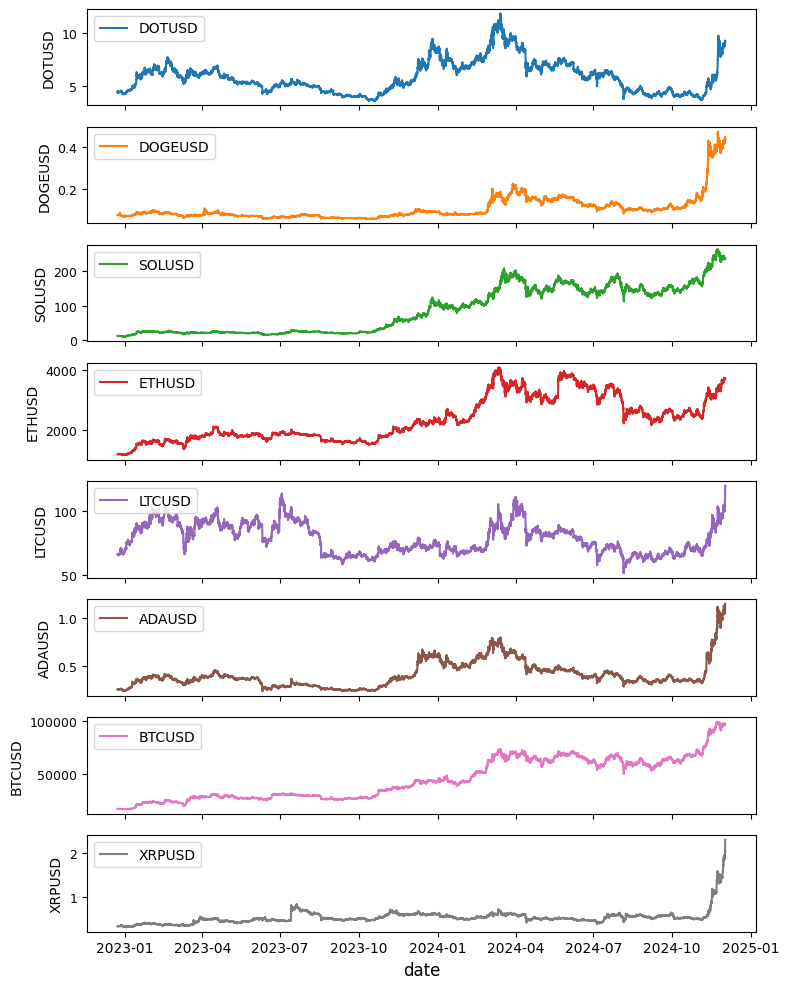

In [211]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define a color palette
colors = sns.color_palette("tab10", len(hourly_data.columns))

# Plot the data
fig, axes = plt.subplots(len(hourly_data.columns), 1, figsize=(8, 10), sharex=True)

for i, column in enumerate(hourly_data.columns):
    axes[i].plot(hourly_data.index, hourly_data[column], color=colors[i], label=column, linewidth=1.5)
    axes[i].legend(loc="upper left", fontsize=10)
    axes[i].set_ylabel(column, fontsize=10)
    axes[i].tick_params(axis="y", labelsize=9)

axes[-1].set_xlabel("date", fontsize=12)
plt.tight_layout()
plt.show()

#### Summary statistics
Summary statistics give us a better idea of the distribution of our data. Useful statistics are:
- **Mean**. The mean of a dataset is the sum of all values divided by the total number of values. It’s the most commonly used measure of central tendency and is often referred to as the “average.”
- **Standard deviation**. The standard deviation is the average amount of variability in your dataset. It tells you, on average, how far each value lies from the mean. A high standard deviation means that values are generally far from the mean, while a low standard deviation indicates that values are clustered close to the mean.
- **Minimum**. The minimum value of a dataset.
- **Median**. The median is the value that’s exactly in the middle of a dataset when it is ordered. It’s a measure of central tendency that separates the lowest 50% from the highest 50% of values. It is also known as the 50% percentile.
- **Maximum**.The maximum value of a dataset.
- **Variance**. The variance is a measure of variability. It is calculated by taking the average of squared deviations from the mean. Variance tells you the degree of spread in your data set. The more spread the data, the larger the variance is in relation to the mean.
- **Skewness**. Skewness is a measure of the asymmetry of a distribution. A positively skewed distribution is longer on the right side of its peak, and a negatively skewed distribution is longer on the left side of its peak.
- **Kurtosis**. Kurtosis is a measure of the tailedness of a distribution, or how often outliers occur. Distributions with low kurtosis have thin tails, while distributions with high kurtosis have fat tails.
- ...

In [212]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

stats = hourly_data.describe()
stats.loc['var'] = hourly_data.var().tolist()
stats.loc['skew'] = hourly_data.skew().tolist()
stats.loc['kurt'] = hourly_data.kurtosis().tolist()

stats

,DOTUSD,DOGEUSD,SOLUSD,ETHUSD,LTCUSD,ADAUSD,BTCUSD,XRPUSD
count,17040.000000,17040.000000,17040.000000,17040.000000,17040.000000,17040.000000,1.704000e+04,17040.000000
mean,5.891815,0.107495,86.332615,2352.168515,78.277295,0.410684,4.483811e+04,0.547477
std,1.511640,0.061214,66.652785,713.091374,11.832245,0.139628,1.944420e+04,0.159248
min,3.609000,0.057500,8.307600,1185.100000,51.160000,0.237910,1.640400e+04,0.325190
25%,4.590750,0.073290,21.794500,1790.575000,68.087500,0.324930,2.741275e+04,0.482030
50%,5.684000,0.085470,72.229250,2222.500000,75.515000,0.376605,4.158150e+04,0.524525
75%,6.770000,0.123762,145.580500,2962.200000,88.200000,0.459103,6.310725e+04,0.596000
max,11.887000,0.475840,263.150800,4069.500000,120.050000,1.148960,9.941400e+04,2.296720
var,2.285056,0.003747,4442.593813,508499.307741,140.002022,0.019496,3.780768e+08,0.025360
skew,0.879216,3.181271,0.398913,0.555533,0.384246,1.719141,4.700100e-01,4.377680


#### Returns
When we construct portfolios, we are more interested in the differences in prices than levels, as we want to focus on how much we can make. Moreover, thinking in differences makes all the series comparable.

In [213]:
# compute returns
hourly_returns = hourly_data.pct_change()[1:]

In [215]:
print(hourly_returns.shape)
hourly_returns.head()

(17039, 8)


,DOTUSD,DOGEUSD,SOLUSD,ETHUSD,LTCUSD,ADAUSD,BTCUSD,XRPUSD
date,,,,,,,,
2022-12-23 01:00:00,-0.039885,0.000000,0.013393,0.001399,0.001057,0.006515,0.000834,-0.000173
2022-12-23 02:00:00,0.000000,0.000000,-0.001935,0.006163,0.002112,0.008101,0.003335,0.001381
2022-12-23 03:00:00,0.000000,0.018219,0.004545,-0.000572,0.002108,0.006229,-0.001187,0.003964
2022-12-23 04:00:00,0.000000,0.000000,0.000000,-0.000327,-0.006160,-0.001070,0.000594,0.001946
2022-12-23 05:00:00,0.000000,0.000000,0.000000,-0.001880,-0.001058,-0.007880,-0.001010,0.000057


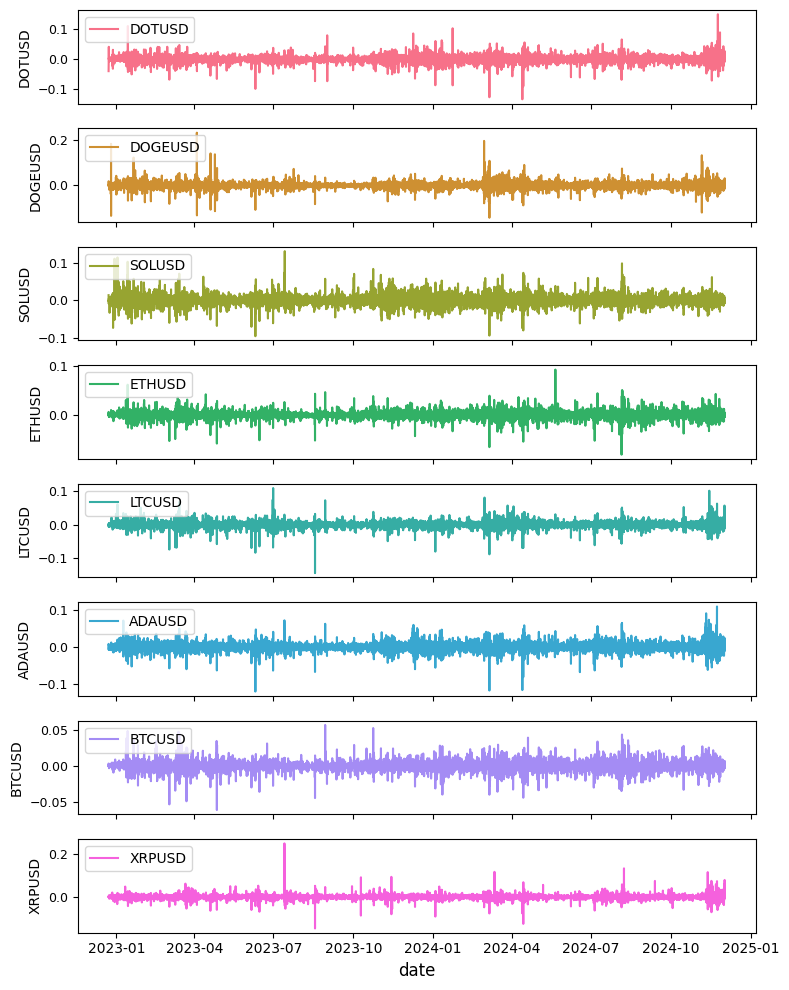

In [216]:
# Define a color palette for returns plot
return_colors = sns.color_palette("husl", len(hourly_returns.columns))

# Plot the returns
fig, axes = plt.subplots(len(hourly_returns.columns), 1, figsize=(8, 10), sharex=True)

for i, column in enumerate(hourly_returns.columns):
    axes[i].plot(hourly_returns.index, hourly_returns[column], color=return_colors[i], label=column, linewidth=1.5)
    axes[i].legend(loc="upper left", fontsize=10)
    axes[i].set_ylabel(column, fontsize=10)
    axes[i].tick_params(axis="y", labelsize=9)

axes[-1].set_xlabel("date", fontsize=12)
plt.tight_layout()
plt.show()


In [217]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

stats_ret = hourly_returns.describe()
stats_ret.loc['var'] = hourly_returns.var().tolist()
stats_ret.loc['skew'] = hourly_returns.skew().tolist()
stats_ret.loc['kurt'] = hourly_returns.kurtosis().tolist()

stats

,DOTUSD,DOGEUSD,SOLUSD,ETHUSD,LTCUSD,ADAUSD,BTCUSD,XRPUSD
count,17040.000000,17040.000000,17040.000000,17040.000000,17040.000000,17040.000000,1.704000e+04,17040.000000
mean,5.891815,0.107495,86.332615,2352.168515,78.277295,0.410684,4.483811e+04,0.547477
std,1.511640,0.061214,66.652785,713.091374,11.832245,0.139628,1.944420e+04,0.159248
min,3.609000,0.057500,8.307600,1185.100000,51.160000,0.237910,1.640400e+04,0.325190
25%,4.590750,0.073290,21.794500,1790.575000,68.087500,0.324930,2.741275e+04,0.482030
50%,5.684000,0.085470,72.229250,2222.500000,75.515000,0.376605,4.158150e+04,0.524525
75%,6.770000,0.123762,145.580500,2962.200000,88.200000,0.459103,6.310725e+04,0.596000
max,11.887000,0.475840,263.150800,4069.500000,120.050000,1.148960,9.941400e+04,2.296720
var,2.285056,0.003747,4442.593813,508499.307741,140.002022,0.019496,3.780768e+08,0.025360
skew,0.879216,3.181271,0.398913,0.555533,0.384246,1.719141,4.700100e-01,4.377680


# Dr. Martina's Portfolio Construction & Evaluation

## Daily Portfolio Construction and Evaluation

In this notebook, I'll show you some of the investment strategies seen in class and how to evaluate them.

### Select assets and time interval

In [273]:
# asset selection
select_asset = 1
if select_asset:
    select = ["BTCUSD","ETHUSD","XRPUSD","ADAUSD","DOGEUSD","DOTUSD","LTCUSD","SOLUSD"] # "MATICUSDT","SOLUSDT","BNBUSDT", "ADAUSDT","DOGEUSDT","DOTUSDT","LTCUSDT"
    daily_returns = daily_returns[select]
    daily_data = daily_data[select]
else:
    daily_returns = daily_returns
    daily_data = daily_data

In [274]:
# date selection
start_series_ret = daily_returns.apply(lambda series: series.first_valid_index())
end_series_ret = daily_returns.apply(lambda series: series.last_valid_index())
start_index_ret = max(start_series_ret)
end_index_ret = min(end_series_ret)
daily_returns = daily_returns.loc[start_index_ret:end_index_ret]

start_series_price = daily_data.apply(lambda series: series.first_valid_index())
end_series_price = daily_data.apply(lambda series: series.last_valid_index())
start_index_price = max(start_series_price)
end_index_price = min(end_series_price)
daily_data = daily_data.loc[start_index_price:end_index_price]

In [275]:
# Checking for null values in prices
daily_data.isnull().any()

,0
BTCUSD,False
ETHUSD,False
XRPUSD,False
ADAUSD,False
DOGEUSD,False
DOTUSD,False
LTCUSD,False
SOLUSD,False


In [276]:
# Checking for null values
daily_returns.isnull().any()

,0
BTCUSD,False
ETHUSD,False
XRPUSD,False
ADAUSD,False
DOGEUSD,False
DOTUSD,False
LTCUSD,False
SOLUSD,False


In [277]:
# number of assets and observations
N_obs = daily_returns.shape[0]
N_assets = daily_returns.shape[1]

### Portfolio allocations

Portfolio style:
1. Long-short       
2. Long-only

In [278]:
# select long-short
style = 1

Constraints for optimization:

In [279]:
# e'w = 1
e = np.ones((N_assets, 1))
Aeq = e.T
beq = 1
eq_constraint = lambda w: np.dot(Aeq, w) - beq
cons = ({'type': 'eq', 'fun': eq_constraint})

# long-short vs long-only
if style:
    lub = (0, 1)
    bnds = ((lub, ) * N_assets)
else:
    bnds = None

# initialize starting vector
w0 = np.ones((N_assets, )) / N_assets

Create variables for portfolio allocations: vector of expected return, covariance matrix, and correlation matrix

In [280]:
ret = np.array(daily_returns)

# Vector of expected returns
mu = np.mean(ret, axis = 0).reshape((N_assets, 1))

# Covariance matrix
Sigma = np.cov(ret.T)

# Vector of volatilities
sigmaVec = np.sqrt(np.diag(Sigma))

# Correlation matrix
corrMatrix = Sigma / np.outer(sigmaVec, sigmaVec)
corrMatrix[Sigma == 0] = 0

In [281]:
print(sigmaVec)

[0.02557189 0.02931019 0.04572052 0.03914291 0.04462567 0.03894976
 0.03591513 0.04827528]


In [282]:
# initialize dataframe to store all portfolio returns
pf_ret = pd.DataFrame()

#### Equally weighted (EW) portfolio

In [283]:
w_EW = 1 / N_assets
rets_EW = w_EW * daily_returns
ret_EW = rets_EW.dropna()
pf_ret['EW'] = ret_EW.sum(axis = 1)

#### Fundamentally weighted (FW) portfolio

In [284]:
# df = pd.read_csv(f'{os.getcwd()}/Binance/{freq}_Volume USDT.csv')
# df.columns = [col.lower() for col in df.columns]  # Convert column names to lowercase
# df.to_csv(f'{os.getcwd()}/Binance/{freq}_Volume USDT.csv', index=False)

In [285]:
freq = 'd'

In [286]:
path = '/content/drive/MyDrive/Final/data/Bitstamp/'

In [287]:
# load data on volume
file_vol = path + freq + '_Volume USD.csv'
vol = pd.read_csv(file_vol)
vol["date"] = pd.to_datetime(vol["date"])
vol.set_index('date', inplace=True)
vol.sort_values(by='date', ascending=True, inplace=True)
vol.drop(vol.tail(1).index,inplace=True)

# select assets and dates
if select_asset:
    select = ["BTCUSD","ETHUSD","XRPUSD","ADAUSD","DOGEUSD","DOTUSD","LTCUSD","SOLUSD"]  # 'bnbusdt', , 'adausdt', 'dogeusdt', 'dotusdt', 'ltcusdt'
    df_vol = vol[select]
else:
    df_vol = vol

start_series_vol = df_vol.apply(lambda series: series.first_valid_index())
end_series_vol = df_vol.apply(lambda series: series.last_valid_index())
start_index_vol = max(start_series_vol)
end_index_vol = min(end_series_vol)
df_vol = df_vol.loc[start_index_vol:end_index_vol]

# portfolio allocation
w_FW = np.array(df_vol.mean() / df_vol.mean().sum())
rets_FW = w_FW * daily_returns
ret_FW = rets_FW.dropna()
pf_ret['FW'] = ret_FW.sum(axis = 1)

#### Minimum variance (MV) portfolio

In [288]:
# optimization
fun_MV = lambda w: np.dot(np.dot(w.T, Sigma), w)
res_MV = optimize.minimize(fun_MV, w0, method='SLSQP', tol=1e-8, bounds=bnds, constraints=cons)

# portfolio allocation
w_MV = res_MV.x
rets_MV = w_MV * daily_returns
ret_MV = rets_MV.dropna()
pf_ret['MV'] = ret_MV.sum(axis = 1)

#### Mean-variance portfolio

In [289]:
# risk aversion parameter
gamma = 2

# optimization
fun_meanvar = lambda w: 0.5 * gamma * np.dot(np.dot(w.T, Sigma), w) - np.dot(w.T, mu)
res_meanvar = optimize.minimize(fun_meanvar, w0, method='SLSQP', tol=1e-8, bounds=bnds, constraints=cons)

# portfolio allocation
w_meanvar = res_meanvar.x
rets_meanvar = w_meanvar * daily_returns
ret_meanvar = rets_meanvar.dropna()
pf_ret['meanvar'] = ret_meanvar.sum(axis = 1)


ret_EW.sum(axis = 1)
ret_FW.sum(axis = 1)
ret_MV.sum(axis = 1)
ret_meanvar.sum(axis = 1)

,0
date,
2022-12-23,0.005900
2022-12-24,-0.027310
2022-12-25,-0.004351
2022-12-26,0.008250
2022-12-27,-0.019655
...,...
2024-11-27,0.051076
2024-11-28,-0.005779
2024-11-29,0.055302


#### Maximum diversification (MD) portfolio

In [290]:
# optimization
fun_MD = lambda w: np.dot(-1*w.T, sigmaVec) / (np.dot(np.dot(w.T, Sigma), w) ** 0.5)
res_MD = optimize.minimize(fun_MD, w0, method='SLSQP', tol=1e-8, bounds=bnds, constraints=cons)

# portfolio allocation
w_MD = res_MD.x
rets_MD = w_MD * daily_returns
ret_MD = rets_MD.dropna()
pf_ret['MD'] = ret_MD.sum(axis = 1)

#### Risk parity (RP) portfolio

In [291]:
# define function to minimize
def RP_func(w, Sigma):
    x = 0
    R = np.dot(Sigma, w)
    for i in range(len(w)):
        for j in range(len(w)):
            x = x + (w[i]*R[i] - w[j]*R[j])**2
    return x

# optimization
fun_RP = lambda w: RP_func(w, Sigma)
res_RP = optimize.minimize(fun_RP, w0, method='SLSQP', tol=1e-15, bounds=bnds, constraints=cons)

# portfolio allocation
w_RP = res_RP.x
rets_RP = w_RP * daily_returns
ret_RP = rets_RP.dropna()
pf_ret['RP'] = ret_RP.sum(axis = 1)

#### Factor investing: momentum

We create a signal based on the time-series of each asset.

In [292]:
# window = 120                  # length of momentum window in days
# reversalLag = -30             # Lenght of reversal window to skip in days

# # initialize
# mom = np.zeros((N_obs, N_assets))
# w_mom = np.ones((N_obs, N_assets)) * np.nan

# # compute momentum and signal
# for i in range(window, N_obs+1):
#     mom[i-1, :] = np.sum(ret[i-window:i+reversalLag, :], axis=0).reshape((1,N_assets))
#     #w_mom[i-1, :] = (mom[i-1, :] - np.mean(mom[i-1, :])) / np.std(mom[i-1, :], ddof=1)
#     w_mom[i-1, :] = mom[i-1, :] / np.sum(mom[i-1, :])

# ret_mom = w_mom * daily_returns
# ret_mom = ret_mom.dropna()
# pf_ret['mom'] = ret_mom.sum(axis = 1)

### Portfolio evaluation

#### Plot cumulative returns

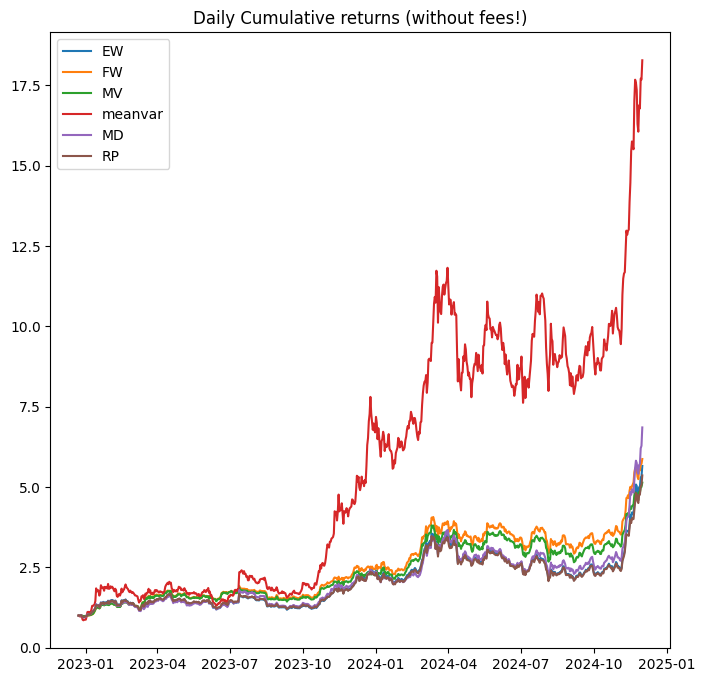

In [293]:
pf_ret = pf_ret.dropna()


plt.figure(figsize=(8, 8))
plt.plot((1+pf_ret['EW']).cumprod(), label='EW')
plt.plot((1+pf_ret['FW']).cumprod(), label='FW')
plt.plot((1+pf_ret['MV']).cumprod(), label='MV')
plt.plot((1+pf_ret['meanvar']).cumprod(), label='meanvar')
plt.plot((1+pf_ret['MD']).cumprod(), label='MD')
plt.plot((1+pf_ret['RP']).cumprod(), label='RP')
#plt.plot((1+pf_ret['mom']).cumprod(), label='mom')
plt.legend()
plt.title('Daily Cumulative returns (without fees!)')
plt.show()

Annualized return and volatility, Sharpe ratio, maximum drawdown

In [294]:
# annualized return and volatility
freq = 'daily'
if freq == 'monthly':
    ann_mean = ((1+pf_ret.mean()) ** 12) - 1
    ann_vol = pf_ret.std() * (12**0.5)
elif freq == 'daily':
    ann_mean = ((1+pf_ret.mean()) ** 365) - 1
    ann_vol = pf_ret.std() * (365**0.5)

# Sharpe ratio
sharpe_ratio = ann_mean / ann_vol

# maximum drawdown
cummulative_return = (1 + pf_ret).cumprod()
previous_peaks = cummulative_return.cummax()
drawdown = (previous_peaks - cummulative_return)/previous_peaks
max_drawdown = abs(drawdown.max())

Summary table for comparison

In [295]:
summ_tab_professor = pd.DataFrame(columns=['EW', 'FW', 'MV', 'meanvar', 'MD', 'RP','mom'])
summ_tab_professor.loc['Annualized return'] = ann_mean
summ_tab_professor.loc['Annualized volatility'] = ann_vol
summ_tab_professor.loc['Sharpe ratio'] = sharpe_ratio
summ_tab_professor.loc['Max DD'] = max_drawdown

summ_tab_professor

,EW,FW,MV,meanvar,MD,RP,mom
Annualized return,1.879068,1.790654,1.600459,5.156495,2.244936,1.773601,NaN
Annualized volatility,0.580545,0.485211,0.481050,0.818669,0.618385,0.563009,NaN
Sharpe ratio,3.236733,3.690465,3.327010,6.298629,3.630322,3.150218,NaN
Max DD,0.411407,0.280709,0.301437,0.365268,0.391324,0.404256,NaN


In [296]:
professor_daily_returns = pf_ret.copy()
print(professor_daily_returns.shape)
professor_daily_returns.head()

(710, 6)


,EW,FW,MV,meanvar,MD,RP
date,,,,,,
2022-12-23,0.000657,-0.000144,-0.000331,0.005900,0.001543,0.000426
2022-12-24,-0.003995,0.001357,0.001816,-0.027310,-0.006002,-0.003081
2022-12-25,0.001981,-0.002338,-0.000245,-0.004351,0.001506,0.002774
2022-12-26,0.013542,0.010918,0.010767,0.008250,0.017369,0.013797
2022-12-27,-0.015490,-0.011657,-0.012285,-0.019655,-0.014047,-0.015264


In [297]:
professor_daily_returns.isnull().any()

,0
EW,False
FW,False
MV,False
meanvar,False
MD,False
RP,False


## Hourly Portfolio Construction and Evaluation

In this notebook, I'll show you some of the investment strategies seen in class and how to evaluate them.

#### Select assets and time interval

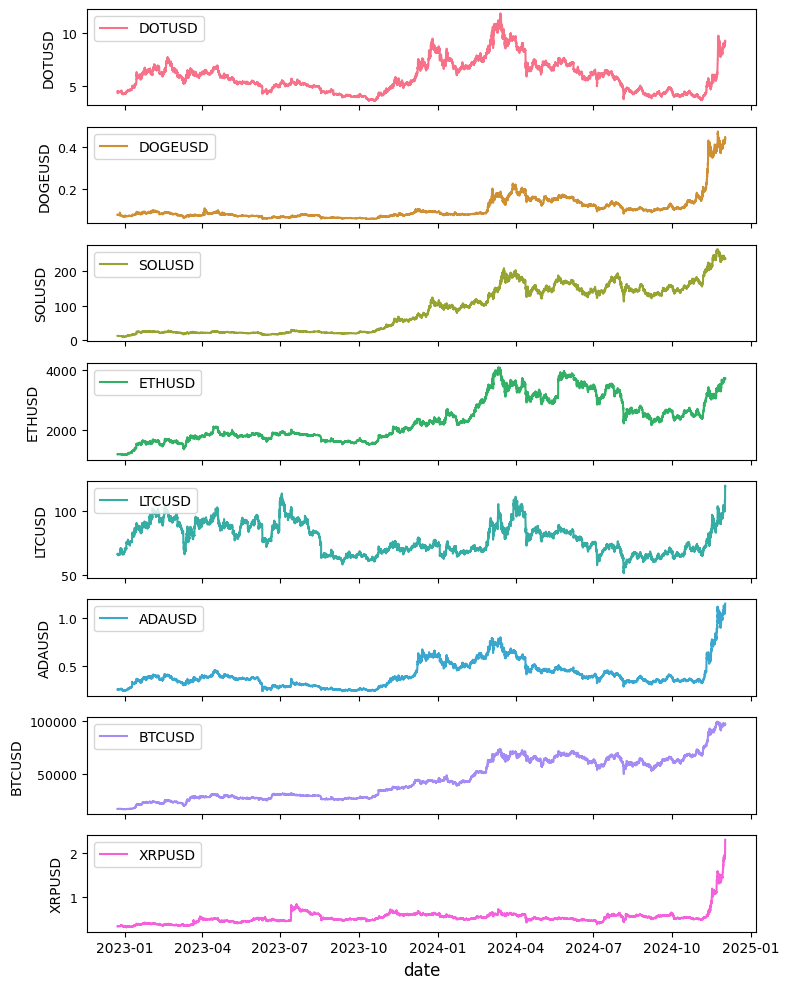

In [298]:
# Define a color palette for returns plot
return_colors = sns.color_palette("husl", len(hourly_data.columns))

# Plot the returns
fig, axes = plt.subplots(len(hourly_data.columns), 1, figsize=(8, 10), sharex=True)

for i, column in enumerate(hourly_data.columns):
    axes[i].plot(hourly_data.index, hourly_data[column], color=return_colors[i], label=column, linewidth=1.5)
    axes[i].legend(loc="upper left", fontsize=10)
    axes[i].set_ylabel(column, fontsize=10)
    axes[i].tick_params(axis="y", labelsize=9)

axes[-1].set_xlabel("date", fontsize=12)
plt.tight_layout()
plt.show()

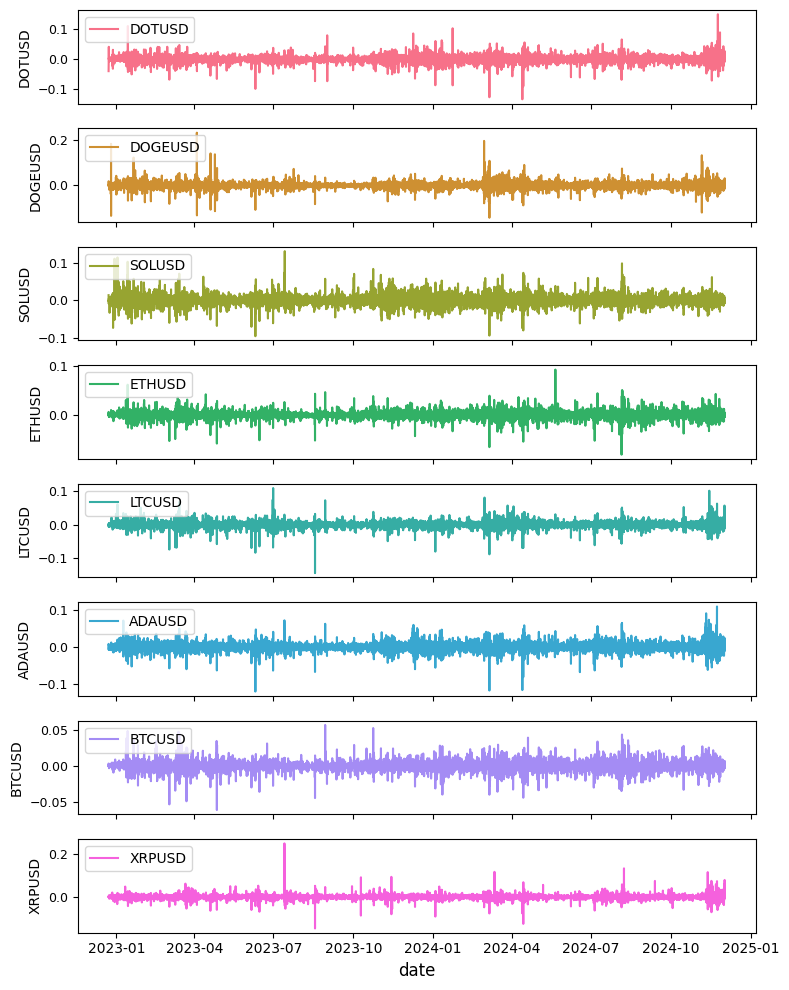

In [299]:
# Define a color palette for returns plot
return_colors = sns.color_palette("husl", len(hourly_returns.columns))

# Plot the returns
fig, axes = plt.subplots(len(hourly_returns.columns), 1, figsize=(8, 10), sharex=True)

for i, column in enumerate(hourly_returns.columns):
    axes[i].plot(hourly_returns.index, hourly_returns[column], color=return_colors[i], label=column, linewidth=1.5)
    axes[i].legend(loc="upper left", fontsize=10)
    axes[i].set_ylabel(column, fontsize=10)
    axes[i].tick_params(axis="y", labelsize=9)

axes[-1].set_xlabel("date", fontsize=12)
plt.tight_layout()
plt.show()

In [300]:
# number of assets and observations
N_obs = hourly_returns.shape[0]
N_assets = hourly_returns.shape[1]

#### Portfolio allocations

Portfolio style:
1. Long-short       
2. Long-only

In [301]:
# select long-short
style = 1

Constraints for optimization:

In [302]:
# e'w = 1
e = np.ones((N_assets, 1))
Aeq = e.T
beq = 1
eq_constraint = lambda w: np.dot(Aeq, w) - beq
cons = ({'type': 'eq', 'fun': eq_constraint})

# long-short vs long-only
if style:
    lub = (0, 1)
    bnds = ((lub, ) * N_assets)
else:
    bnds = None

# initialize starting vector
w0 = np.ones((N_assets, )) / N_assets

Create variables for portfolio allocations: vector of expected return, covariance matrix, and correlation matrix

In [303]:
ret = np.array(hourly_returns)

# Vector of expected returns
mu = np.mean(ret, axis = 0).reshape((N_assets, 1))

# Covariance matrix
Sigma = np.cov(ret.T)

# Vector of volatilities
sigmaVec = np.sqrt(np.diag(Sigma))

# Correlation matrix
corrMatrix = Sigma / np.outer(sigmaVec, sigmaVec)
corrMatrix[Sigma == 0] = 0

In [304]:
print(sigmaVec)

[0.00869795 0.01075807 0.01036727 0.00584363 0.00751678 0.00865565
 0.00505071 0.00841797]


In [305]:
# initialize dataframe to store all portfolio returns
hourly_pf_ret = pd.DataFrame()

#### Equally weighted (EW) portfolio

In [306]:
w_EW = 1 / N_assets
ret_EW = w_EW * hourly_returns
ret_EW = ret_EW.dropna()
hourly_pf_ret['EW'] = ret_EW.sum(axis = 1)

#### Fundamentally weighted (FW) portfolio

In [307]:
freq='1h'

In [308]:
# load data on volume
file_vol = path + freq + '_Volume USD.csv'
vol = pd.read_csv(file_vol)
vol["date"] = pd.to_datetime(vol["date"])
vol.set_index('date', inplace=True)
vol.sort_values(by='date', ascending=True, inplace=True)
vol.drop(vol.tail(1).index,inplace=True)

# select assets and dates
if select_asset:
    select = ["BTCUSD","ETHUSD","XRPUSD","ADAUSD","DOGEUSD","DOTUSD","LTCUSD","SOLUSD"]
    df_vol = vol[select]
else:
    df_vol = vol

start_series_vol = df_vol.apply(lambda series: series.first_valid_index())
end_series_vol = df_vol.apply(lambda series: series.last_valid_index())
start_index_vol = max(start_series_vol)
end_index_vol = min(end_series_vol)
df_vol = df_vol.loc[start_index_vol:end_index_vol]

# portfolio allocation
w_FW = np.array(df_vol.mean() / df_vol.mean().sum())
ret_FW = w_FW * hourly_returns
ret_FW = ret_FW.dropna()
hourly_pf_ret['FW'] = ret_FW.sum(axis = 1)

#### Minimum variance (MV) portfolio

In [309]:
# optimization
fun_MV = lambda w: np.dot(np.dot(w.T, Sigma), w)
res_MV = optimize.minimize(fun_MV, w0, method='SLSQP', tol=1e-8, bounds=bnds, constraints=cons)

# portfolio allocation
w_MV = res_MV.x
ret_MV = w_MV * hourly_returns
ret_MV = ret_MV.dropna()
hourly_pf_ret['MV'] = ret_MV.sum(axis = 1)

#### Mean-variance portfolio

In [310]:
# risk aversion parameter
gamma = 2

# optimization
fun_meanvar = lambda w: 0.5 * gamma * np.dot(np.dot(w.T, Sigma), w) - np.dot(w.T, mu)
res_meanvar = optimize.minimize(fun_meanvar, w0, method='SLSQP', tol=1e-8, bounds=bnds, constraints=cons)

# portfolio allocation
w_meanvar = res_meanvar.x
ret_meanvar = w_meanvar * hourly_returns
ret_meanvar = ret_meanvar.dropna()
hourly_pf_ret['meanvar'] = ret_meanvar.sum(axis = 1)

#### Maximum diversification (MD) portfolio

In [311]:
# optimization
fun_MD = lambda w: np.dot(-1*w.T, sigmaVec) / (np.dot(np.dot(w.T, Sigma), w) ** 0.5)
res_MD = optimize.minimize(fun_MD, w0, method='SLSQP', tol=1e-8, bounds=bnds, constraints=cons)

# portfolio allocation
w_MD = res_MD.x
ret_MD = w_MD * hourly_returns
ret_MD = ret_MD.dropna()
hourly_pf_ret['MD'] = ret_MD.sum(axis = 1)

#### Risk parity (RP) portfolio

In [312]:
# define function to minimize
def RP_func(w, Sigma):
    x = 0
    R = np.dot(Sigma, w)
    for i in range(len(w)):
        for j in range(len(w)):
            x = x + (w[i]*R[i] - w[j]*R[j])**2
    return x

# optimization
fun_RP = lambda w: RP_func(w, Sigma)
res_RP = optimize.minimize(fun_RP, w0, method='SLSQP', tol=1e-15, bounds=bnds, constraints=cons)

# portfolio allocation
w_RP = res_RP.x
ret_RP = w_RP * hourly_returns
ret_RP = ret_RP.dropna()
hourly_pf_ret['RP'] = ret_RP.sum(axis = 1)

In [313]:
hourly_pf_ret.head()

,EW,FW,MV,meanvar,MD,RP
date,,,,,,
2022-12-23 01:00:00,-0.002107,-0.027870,-0.002107,0.006044,-0.005955,-0.002107
2022-12-23 02:00:00,0.002395,-0.000101,0.002395,0.000544,0.000741,0.002395
2022-12-23 03:00:00,0.004163,0.002872,0.004163,0.005693,0.005285,0.004163
2022-12-23 04:00:00,-0.000627,-0.000003,-0.000627,0.000414,-0.000125,-0.000627
2022-12-23 05:00:00,-0.001471,-0.000027,-0.001471,-0.000646,-0.000368,-0.001471


#### Factor investing: momentum

We create a signal based on the time-series of each asset.

In [314]:
# window = 120                  # length of momentum window in days
# reversalLag = -30             # Lenght of reversal window to skip in days

# # initialize
# mom = np.zeros((N_obs, N_assets))
# w_mom = np.ones((N_obs, N_assets)) * np.nan

# # compute momentum and signal
# for i in range(window, N_obs+1):
#     mom[i-1, :] = np.sum(ret[i-window:i+reversalLag, :], axis=0).reshape((1,N_assets))
#     #w_mom[i-1, :] = (mom[i-1, :] - np.mean(mom[i-1, :])) / np.std(mom[i-1, :], ddof=1)
#     w_mom[i-1, :] = mom[i-1, :] / np.sum(mom[i-1, :])

# ret_mom = w_mom * hourly_returns
# ret_mom = ret_mom.dropna()
# pf_ret['mom'] = ret_mom.sum(axis = 1)

In [315]:
# import numpy as np
# import pandas as pd

# # Assuming 'hourly_returns' is your DataFrame of hourly returns with N_obs and N_assets

# # Set new momentum window for hourly data (adjust for your needs)
# window = 120 * 24  # 120 days * 6 hours/day = 720 hours for the momentum window
# reversalLag = -30 * 24  # 30 days * 6 hours/day = 180 hours for the reversal window

# # Initialize arrays
# N_obs = len(hourly_returns)  # Number of hourly observations
# N_assets = hourly_returns.shape[1]  # Number of assets
# mom = np.zeros((N_obs, N_assets))  # To store momentum signals
# w_mom = np.ones((N_obs, N_assets)) * np.nan  # To store normalized momentum weights

# # Compute momentum and signal
# for i in range(window, N_obs + 1):
#     # Momentum calculation: sum of returns over the momentum window and reversal lag
#     mom[i-1, :] = np.sum(hourly_returns[i - window:i + reversalLag, :], axis=0).reshape((1, N_assets))

#     # Normalize momentum (optional)
#     # w_mom[i-1, :] = (mom[i-1, :] - np.mean(mom[i-1, :])) / np.std(mom[i-1, :], ddof=1)

#     # Weights based on momentum (sum of momentum)
#     w_mom[i-1, :] = mom[i-1, :] / np.sum(mom[i-1, :])

# # Calculate portfolio returns using momentum weights
# ret_mom = w_mom * hourly_returns.values  # Element-wise multiplication with hourly returns
# ret_mom = pd.DataFrame(ret_mom).dropna()  # Drop any NaN values

# # Calculate total momentum strategy returns
# pf_ret = pd.DataFrame()
# pf_ret['mom'] = ret_mom.sum(axis=1)  # Sum across assets for portfolio return

# # Display results
# print("Momentum Strategy Portfolio Returns (Hourly):")
# print(pf_ret['mom'])


### Portfolio evaluation

Annualized return and volatility, Sharpe ratio, maximum drawdown

In [316]:
# annualized return and volatility
freq = 'hourly'
if freq == 'daily':
    ann_mean = ((1+hourly_pf_ret.mean()) ** 365) - 1
    ann_vol = hourly_pf_ret.std() * (365**0.5)
elif freq == 'hourly':
    ann_mean = ((1+hourly_pf_ret.mean()) ** (365*24)) - 1
    ann_vol = hourly_pf_ret.std() * ((365*24)**0.5)

# Sharpe ratio
sharpe_ratio = ann_mean / ann_vol

# maximum drawdown
cummulative_return = (1 + hourly_pf_ret).cumprod()
previous_peaks = cummulative_return.cummax()
drawdown = (previous_peaks - cummulative_return)/previous_peaks
max_drawdown = abs(drawdown.max())

Summary table for comparison

In [317]:
summ_tab = pd.DataFrame(columns=['EW', 'FW', 'MV', 'meanvar', 'MD', 'RP']) # 'mom'
summ_tab.loc['Annualized return'] = ann_mean
summ_tab.loc['Annualized volatility'] = ann_vol
summ_tab.loc['Sharpe ratio'] = sharpe_ratio
summ_tab.loc['Max DD'] = max_drawdown

summ_tab

,EW,FW,MV,meanvar,MD,RP
Annualized return,1.995344,1.545571,1.995344,3.675977,2.289955,1.995344
Annualized volatility,0.590334,0.734561,0.590334,0.681940,0.626316,0.590334
Sharpe ratio,3.380027,2.104074,3.380027,5.390466,3.656231,3.380027
Max DD,0.475284,0.621001,0.475284,0.423365,0.473469,0.475284


In [318]:
hourly_pf_ret.dropna(inplace=True)

In [319]:
hourly_pf_ret.head()

,EW,FW,MV,meanvar,MD,RP
date,,,,,,
2022-12-23 01:00:00,-0.002107,-0.027870,-0.002107,0.006044,-0.005955,-0.002107
2022-12-23 02:00:00,0.002395,-0.000101,0.002395,0.000544,0.000741,0.002395
2022-12-23 03:00:00,0.004163,0.002872,0.004163,0.005693,0.005285,0.004163
2022-12-23 04:00:00,-0.000627,-0.000003,-0.000627,0.000414,-0.000125,-0.000627
2022-12-23 05:00:00,-0.001471,-0.000027,-0.001471,-0.000646,-0.000368,-0.001471


In [320]:
professor_hourly_portfolio_returns = hourly_pf_ret.copy()

In [321]:
professor_hourly_portfolio_returns.head()

,EW,FW,MV,meanvar,MD,RP
date,,,,,,
2022-12-23 01:00:00,-0.002107,-0.027870,-0.002107,0.006044,-0.005955,-0.002107
2022-12-23 02:00:00,0.002395,-0.000101,0.002395,0.000544,0.000741,0.002395
2022-12-23 03:00:00,0.004163,0.002872,0.004163,0.005693,0.005285,0.004163
2022-12-23 04:00:00,-0.000627,-0.000003,-0.000627,0.000414,-0.000125,-0.000627
2022-12-23 05:00:00,-0.001471,-0.000027,-0.001471,-0.000646,-0.000368,-0.001471


In [322]:
professor_hourly_portfolio_returns.isnull().any()

,0
EW,False
FW,False
MV,False
meanvar,False
MD,False
RP,False


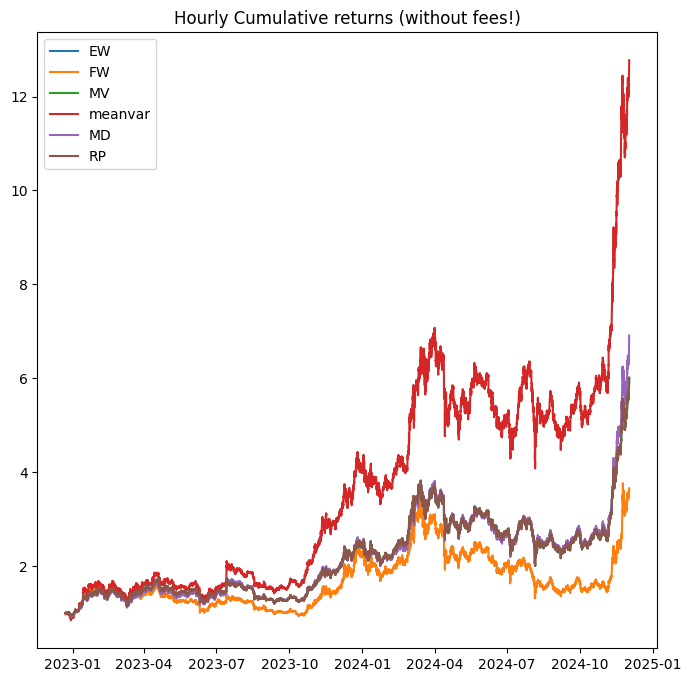

In [323]:
hourly_pf_ret = hourly_pf_ret.dropna()


plt.figure(figsize=(8, 8))
plt.plot((1+hourly_pf_ret['EW']).cumprod(), label='EW')
plt.plot((1+hourly_pf_ret['FW']).cumprod(), label='FW')
plt.plot((1+hourly_pf_ret['MV']).cumprod(), label='MV')
plt.plot((1+hourly_pf_ret['meanvar']).cumprod(), label='meanvar')
plt.plot((1+hourly_pf_ret['MD']).cumprod(), label='MD')
plt.plot((1+hourly_pf_ret['RP']).cumprod(), label='RP')
#plt.plot((1+pf_ret['mom']).cumprod(), label='mom')
plt.legend()
plt.title('Hourly Cumulative returns (without fees!)')
plt.show()

# Portfolio construction and evaluation

In this notebook, I'll show you some of the investment strategies seen in class and how to evaluate them.

### Select assets and time interval

In [325]:
# Group the data by month and calculate the standard deviation for each group
hrdaily_returns_std = professor_hourly_portfolio_returns.groupby(pd.Grouper(freq='D')).std() * np.sqrt(24)

In [326]:
hrdaily_returns_std.head()

,EW,FW,MV,meanvar,MD,RP
date,,,,,,
2022-12-23,0.012758,0.043689,0.012758,0.017030,0.016111,0.012758
2022-12-24,0.007789,0.008736,0.007789,0.016311,0.008435,0.007789
2022-12-25,0.033001,0.033142,0.033001,0.040109,0.046964,0.033001
2022-12-26,0.009576,0.011919,0.009576,0.012656,0.010389,0.009576
2022-12-27,0.012903,0.024086,0.012903,0.019173,0.016166,0.012903


In [327]:
hrdaily_returns_std.isnull().any()

,0
EW,False
FW,False
MV,False
meanvar,False
MD,False
RP,False


### Professor's Strategies Daily Std

### Professor's Strategies Daily Returns

In [328]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")
passive_strategy_std = dict(professor_daily_returns.std())

In [329]:
passive_strategy_std

{'EW': 0.030387093703226897,
 'FW': 0.025397096629366827,
 'MV': 0.025179315886149075,
 'meanvar': 0.04285111312368396,
 'MD': 0.03236773324466795,
 'RP': 0.029469230949046417}

In [330]:
np.random.seed(0)
random_target = float(np.random.rand(1))
random_target

0.5488135039273248

In [331]:
WTplus1_prof = hrdaily_returns_std / random_target
WTplus1_prof.index = WTplus1_prof.index + pd.Timedelta(days=1)
WTplus1_prof = WTplus1_prof[:-1]
print(WTplus1_prof.shape)
WTplus1_prof

(709, 6)


,EW,FW,MV,meanvar,MD,RP
date,,,,,,
2022-12-24,0.023247,0.079606,0.023247,0.031030,0.029357,0.023247
2022-12-25,0.014193,0.015919,0.014193,0.029720,0.015369,0.014193
2022-12-26,0.060132,0.060389,0.060132,0.073084,0.085573,0.060132
2022-12-27,0.017448,0.021718,0.017448,0.023061,0.018931,0.017448
2022-12-28,0.023510,0.043887,0.023510,0.034936,0.029456,0.023510
...,...,...,...,...,...,...
2024-11-27,0.102517,0.179799,0.102517,0.103368,0.112833,0.102517
2024-11-28,0.064986,0.090634,0.064986,0.065450,0.074347,0.064986
2024-11-29,0.055269,0.093638,0.055269,0.052129,0.060410,0.055269


In [332]:
print(professor_daily_returns.shape)
WTplus1_prof.shape

(710, 6)


(709, 6)

In [333]:
estimated_return = WTplus1_prof * professor_daily_returns
estimated_return = estimated_return[1:]
estimated_return

,EW,FW,MV,meanvar,MD,RP
date,,,,,,
2022-12-24,-0.000093,0.000108,0.000042,-0.000847,-0.000176,-0.000072
2022-12-25,0.000028,-0.000037,-0.000003,-0.000129,0.000023,0.000039
2022-12-26,0.000814,0.000659,0.000647,0.000603,0.001486,0.000830
2022-12-27,-0.000270,-0.000253,-0.000214,-0.000453,-0.000266,-0.000266
2022-12-28,-0.000972,-0.000672,-0.000333,-0.003304,-0.001404,-0.000884
...,...,...,...,...,...,...
2024-11-27,0.005625,0.009407,0.005919,0.005280,0.005801,0.005735
2024-11-28,0.000206,-0.000062,-0.000257,-0.000378,0.000408,0.000133
2024-11-29,0.003213,0.003148,0.001698,0.002883,0.005114,0.003093


In [334]:
estimated_return_std = dict(estimated_return.std())
estimated_return_std

{'EW': 0.0020979710457597733,
 'FW': 0.0021548821981493575,
 'MV': 0.0017018347376184838,
 'meanvar': 0.0032803402514318732,
 'MD': 0.0023085797868179097,
 'RP': 0.002032259930397079}

In [335]:
strategies = estimated_return_std.keys()
strategies

dict_keys(['EW', 'FW', 'MV', 'meanvar', 'MD', 'RP'])

In [336]:
from scipy.optimize import minimize

#targets = np.linspace(0,1,100)
#for target in targets:
my_targets={}
for strategy in strategies:

  # Example input data
  passive_strategy_ = passive_strategy_std[strategy]
  estimated_return_ = estimated_return_std[strategy]
  professor_daily_return_ = professor_daily_returns[strategy]

  # Define the function to minimize
  def objective_function(target):
      return abs(passive_strategy_ - estimated_return_)

  # Initial guess for the 'target'
  initial_guess = random.random()

  # Solve for the target using scipy.optimize
  result = minimize(objective_function, initial_guess, method='Nelder-Mead')

  # Get the optimized target
  optimized_target = result.x[0]

  # Output the result
  my_targets[strategy]=optimized_target
  #print(f"Optimized Target: {optimized_target}")
  # print(f"Passive Strategy Std: {passive_strategy_}")
  # print(f"Estimated Return Std with Optimized Target: {(optimized_target / estimated_return_) * daily_returns}")

my_targets

{'EW': 0.07959423128381615,
 'FW': 0.7096527921703613,
 'MV': 0.6251457266081297,
 'meanvar': 0.5860947209774318,
 'MD': 0.7676677364074083,
 'RP': 0.2754708805506023}

In [338]:
strategies = list(strategies)

In [339]:
strategies

['EW', 'FW', 'MV', 'meanvar', 'MD', 'RP']

In [340]:
WTplus1_ours = {}

In [341]:
for i in strategies:
 WTplus1_ours[i]=   hrdaily_returns_std[i] / my_targets[i]

In [342]:
WTplus1_ours

{'EW': date
 2022-12-23    0.160294
 2022-12-24    0.097861
 2022-12-25    0.414620
 2022-12-26    0.120304
 2022-12-27    0.162104
                 ...   
 2024-11-27    0.448089
 2024-11-28    0.381087
 2024-11-29    0.376665
 2024-11-30    0.400612
 2024-12-01    0.446856
 Freq: D, Name: EW, Length: 710, dtype: float64,
 'FW': date
 2022-12-23    0.061564
 2022-12-24    0.012311
 2022-12-25    0.046702
 2022-12-26    0.016796
 2022-12-27    0.033940
                 ...   
 2024-11-27    0.070092
 2024-11-28    0.072415
 2024-11-29    0.065495
 2024-11-30    0.089216
 2024-12-01    0.054527
 Freq: D, Name: FW, Length: 710, dtype: float64,
 'MV': date
 2022-12-23    0.020409
 2022-12-24    0.012460
 2022-12-25    0.052790
 2022-12-26    0.015317
 2022-12-27    0.020639
                 ...   
 2024-11-27    0.057051
 2024-11-28    0.048520
 2024-11-29    0.047957
 2024-11-30    0.051006
 2024-12-01    0.056894
 Freq: D, Name: MV, Length: 710, dtype: float64,
 'meanvar': date
 2022-12

In [343]:
WTplus1_ours=pd.DataFrame(WTplus1_ours)
WTplus1_ours.index = WTplus1_ours.index + pd.Timedelta(days=1)
WTplus1_ours = WTplus1_ours[:-1]
WTplus1_ours

,EW,FW,MV,meanvar,MD,RP
date,,,,,,
2022-12-24,0.160294,0.061564,0.020409,0.029057,0.020987,0.046315
2022-12-25,0.097861,0.012311,0.012460,0.027830,0.010987,0.028276
2022-12-26,0.414620,0.046702,0.052790,0.068435,0.061177,0.119800
2022-12-27,0.120304,0.016796,0.015317,0.021594,0.013534,0.034761
2022-12-28,0.162104,0.033940,0.020639,0.032713,0.021058,0.046838
...,...,...,...,...,...,...
2024-11-27,0.706867,0.139048,0.089999,0.096793,0.080665,0.204241
2024-11-28,0.448089,0.070092,0.057051,0.061287,0.053151,0.129470
2024-11-29,0.381087,0.072415,0.048520,0.048813,0.043188,0.110111


In [344]:
professor_daily_returns.shape

(710, 6)

In [345]:
our_returns = WTplus1_ours * professor_daily_returns
our_returns = our_returns[1:]
our_returns

,EW,FW,MV,meanvar,MD,RP
date,,,,,,
2022-12-24,-0.000640,0.000084,0.000037,-0.000794,-0.000126,-0.000143
2022-12-25,0.000194,-0.000029,-0.000003,-0.000121,0.000017,0.000078
2022-12-26,0.005615,0.000510,0.000568,0.000565,0.001063,0.001653
2022-12-27,-0.001863,-0.000196,-0.000188,-0.000424,-0.000190,-0.000531
2022-12-28,-0.006703,-0.000519,-0.000292,-0.003094,-0.001004,-0.001761
...,...,...,...,...,...,...
2024-11-27,0.038787,0.007275,0.005196,0.004944,0.004147,0.011425
2024-11-28,0.001422,-0.000048,-0.000226,-0.000354,0.000292,0.000265
2024-11-29,0.022157,0.002434,0.001491,0.002699,0.003656,0.006161


In [359]:
# annualized return and volatility
freq = 'daily'
if freq == 'monthly':
    ann_mean = ((1+pf_ret.mean()) ** 12) - 1
    ann_vol = pf_ret.std() * (12**0.5)
elif freq == 'daily':
    ann_mean = ((1+pf_ret.mean()) ** 365) - 1
    ann_vol = pf_ret.std() * (365**0.5)

# Sharpe ratio
sharpe_ratio = ann_mean / ann_vol

# maximum drawdown
cummulative_return = (1 + pf_ret).cumprod()
previous_peaks = cummulative_return.cummax()
drawdown = (previous_peaks - cummulative_return)/previous_peaks
max_drawdown = abs(drawdown.max())

summ_tab_professor = pd.DataFrame(columns=['EW', 'FW', 'MV', 'meanvar', 'MD', 'RP'])
summ_tab_professor.loc['Annualized return'] = ann_mean
summ_tab_professor.loc['Annualized volatility'] = ann_vol
summ_tab_professor.loc['Sharpe ratio'] = sharpe_ratio
summ_tab_professor.loc['Max DD'] = max_drawdown

summ_tab_professor

,EW,FW,MV,meanvar,MD,RP
Annualized return,1.879068,1.790654,1.600459,5.156495,2.244936,1.773601
Annualized volatility,0.580545,0.485211,0.481050,0.818669,0.618385,0.563009
Sharpe ratio,3.236733,3.690465,3.327010,6.298629,3.630322,3.150218
Max DD,0.411407,0.280709,0.301437,0.365268,0.391324,0.404256


In [360]:
# annualized return and volatility
freq = 'daily'
if freq == 'monthly':
    ann_mean = ((1+our_returns.mean()) ** 12) - 1
    ann_vol = our_returns.std() * (12**0.5)
elif freq == 'daily':
    ann_mean = ((1+our_returns.mean()) ** 365) - 1
    ann_vol = our_returns.std() * (365**0.5)

# Sharpe ratio
sharpe_ratio = ann_mean / ann_vol

# maximum drawdown
cummulative_return = (1 + our_returns).cumprod()
previous_peaks = cummulative_return.cummax()
drawdown = (previous_peaks - cummulative_return)/previous_peaks
max_drawdown = abs(drawdown.max())

summ_tab_strategy = pd.DataFrame(columns=['EW', 'FW', 'MV', 'meanvar', 'MD', 'RP'])
summ_tab_strategy.loc['Annualized return'] = ann_mean
summ_tab_strategy.loc['Annualized volatility'] = ann_vol
summ_tab_strategy.loc['Sharpe ratio'] = sharpe_ratio
summ_tab_strategy.loc['Max DD'] = max_drawdown

summ_tab_strategy

,EW,FW,MV,meanvar,MD,RP
Annualized return,0.772157,0.061013,0.055469,0.158411,0.070363,0.170825
Annualized volatility,0.276369,0.031838,0.028544,0.058684,0.031531,0.077353
Sharpe ratio,2.793936,1.916344,1.943307,2.699366,2.231510,2.208397
Max DD,0.222772,0.029315,0.025339,0.025200,0.021993,0.064849


In [361]:
our_return_mu = dict(our_returns.mean())
our_return_mu

{'EW': 0.00156889346777674,
 'FW': 0.00016227101352698532,
 'MV': 0.000147915107088916,
 'meanvar': 0.00040295476735117714,
 'MD': 0.0001863116878772508,
 'RP': 0.0004321722886967882}

In [362]:
professor_mu = dict(professor_daily_returns.mean())
professor_mu

{'EW': 0.0029013697730471744,
 'FW': 0.002815671249238485,
 'MV': 0.0026217537472082593,
 'meanvar': 0.004991891036977246,
 'MD': 0.0032301249801065567,
 'RP': 0.0027988312333682864}

In [363]:
final_ans = {}

In [364]:
for i in professor_mu.keys():
  final_ans[i]=our_return_mu[i]-professor_mu[i]
final_ans

{'EW': -0.0013324763052704346,
 'FW': -0.0026534002357114996,
 'MV': -0.0024738386401193433,
 'meanvar': -0.004588936269626069,
 'MD': -0.003043813292229306,
 'RP': -0.0023666589446714984}

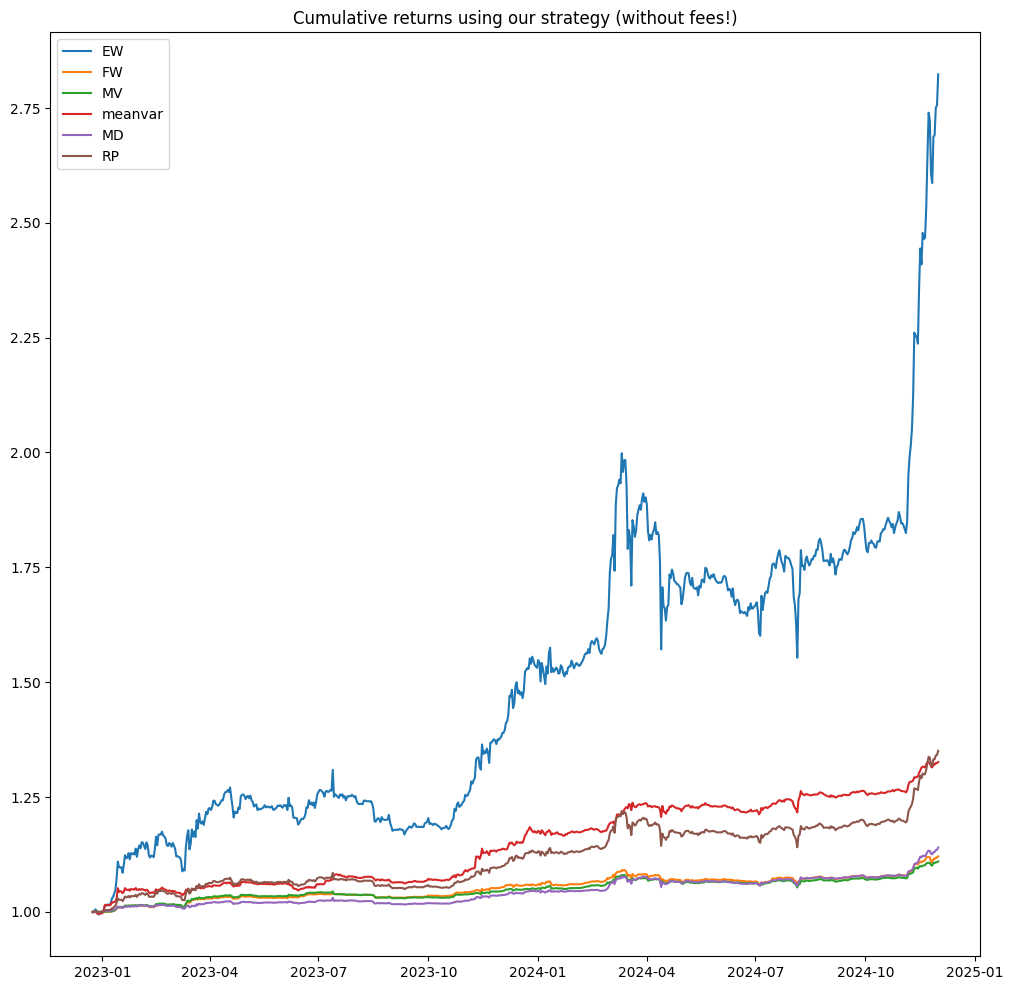

In [368]:
our_pf_ret = our_returns.dropna()


plt.figure(figsize=(12, 12))
plt.plot((1+our_pf_ret['EW']).cumprod(), label='EW')
plt.plot((1+our_pf_ret['FW']).cumprod(), label='FW')
plt.plot((1+our_pf_ret['MV']).cumprod(), label='MV')
plt.plot((1+our_pf_ret['meanvar']).cumprod(), label='meanvar')
plt.plot((1+our_pf_ret['MD']).cumprod(), label='MD')
plt.plot((1+our_pf_ret['RP']).cumprod(), label='RP')
#plt.plot((1+pf_ret['mom']).cumprod(), label='mom')
plt.legend()
plt.title('Cumulative returns using our strategy (without fees!)')
plt.show()

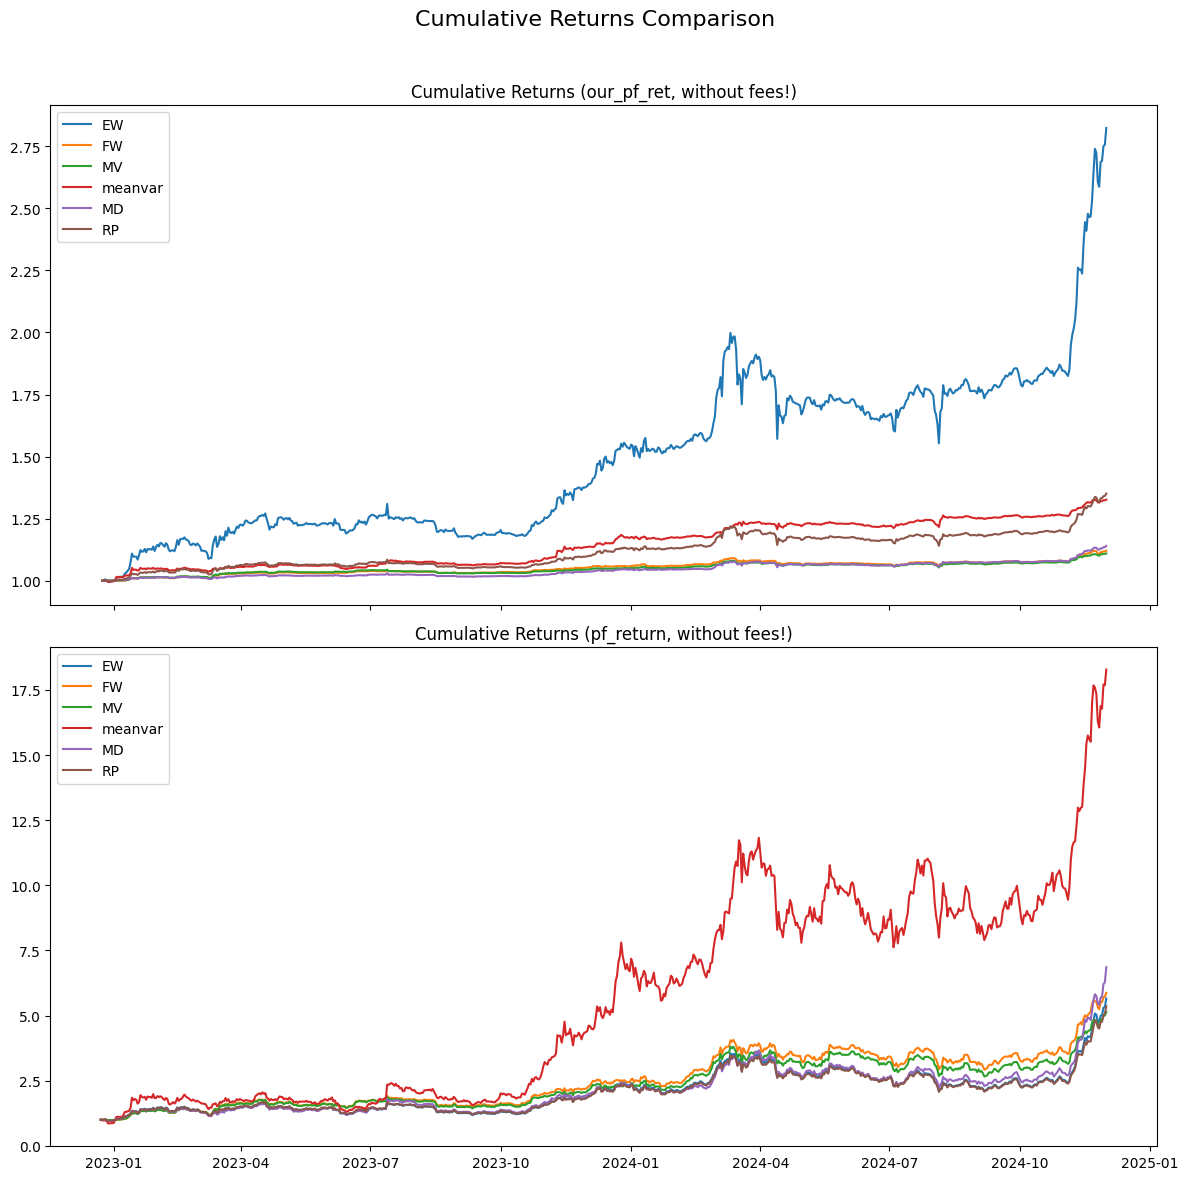

In [369]:
import matplotlib.pyplot as plt

# Ensure the data is ready for plotting
our_pf_ret = our_returns.dropna()
pf_return = pf_ret.dropna()

# Create a single figure with two subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 12), sharex=True)

# Plot the first dataset in the first subplot
axes[0].plot((1 + our_pf_ret['EW']).cumprod(), label='EW')
axes[0].plot((1 + our_pf_ret['FW']).cumprod(), label='FW')
axes[0].plot((1 + our_pf_ret['MV']).cumprod(), label='MV')
axes[0].plot((1 + our_pf_ret['meanvar']).cumprod(), label='meanvar')
axes[0].plot((1 + our_pf_ret['MD']).cumprod(), label='MD')
axes[0].plot((1 + our_pf_ret['RP']).cumprod(), label='RP')
axes[0].legend()
axes[0].set_title('Cumulative Returns (our_pf_ret, without fees!)')

# Plot the second dataset in the second subplot
axes[1].plot((1 + pf_return['EW']).cumprod(), label='EW')
axes[1].plot((1 + pf_return['FW']).cumprod(), label='FW')
axes[1].plot((1 + pf_return['MV']).cumprod(), label='MV')
axes[1].plot((1 + pf_return['meanvar']).cumprod(), label='meanvar')
axes[1].plot((1 + pf_return['MD']).cumprod(), label='MD')
axes[1].plot((1 + pf_return['RP']).cumprod(), label='RP')
axes[1].legend()
axes[1].set_title('Cumulative Returns (pf_return, without fees!)')

# Add an overall title to the figure
fig.suptitle('Cumulative Returns Comparison', fontsize=16)

# Display the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make space for the suptitle
plt.show()


# Hierarchical Risk Parity (HRP)

The HRP method works by finding subclusters of similar assets based on returns and constructing a hierarchy from these clusters to generate weights for each asset.

Here, we will use the max Sharpe statistic. The Sharpe ratio is the ratio between returns and risk. The lower the risk and the higher the returns, the higher the Sharpe ratio. The algorithm looks for the maximum Sharpe ratio, which translates to the portfolio with the highest return and lowest risk. Ultimately, the higher the Sharpe ratio, the better the performance of the portfolio.

In [370]:
from pypfopt import expected_returns

rets = expected_returns.returns_from_prices(daily_data)
rets.tail()

,BTCUSD,ETHUSD,XRPUSD,ADAUSD,DOGEUSD,DOTUSD,LTCUSD,SOLUSD
date,,,,,,,,
2024-11-27,0.044056,0.100782,0.052574,0.055141,0.037474,0.049671,0.048594,0.050682
2024-11-28,-0.003303,-0.021488,0.048480,0.016963,0.001420,0.021767,-0.018393,-0.020054
2024-11-29,0.019350,0.004191,0.167859,0.041459,0.060274,0.048744,0.097561,0.025689
2024-11-30,-0.010983,0.031160,0.084063,0.004697,-0.009549,-0.010157,-0.021459,-0.024250
2024-12-01,0.008814,0.001025,0.175641,0.063655,0.045196,0.030225,0.166277,-0.003266


In [371]:
mu = mean_historical_return(daily_data)
S = CovarianceShrinkage(daily_data).ledoit_wolf()

In [372]:
# ef = EfficientFrontier(mu, S) # Long-only
ef = EfficientFrontier(mu, S, weight_bounds=(-1,1)) #long-short
weights = ef.min_volatility()

cleaned_weights = ef.clean_weights()
print(dict(cleaned_weights))

{'BTCUSD': 0.80566, 'ETHUSD': 0.20885, 'XRPUSD': 0.09521, 'ADAUSD': -0.05602, 'DOGEUSD': -0.12464, 'DOTUSD': 0.06758, 'LTCUSD': 0.12956, 'SOLUSD': -0.12621}


In [373]:
# display portfolio performance
ef.portfolio_performance(verbose=True)

Expected annual return: 55.1%
Annual volatility: 38.6%
Sharpe Ratio: 1.43


(0.551480745868802, 0.3856600007934029, 1.4299661482504349)

In [374]:
# Run the optimization algorithm to get the weights:
hrp = HRPOpt(rets)
hrp.optimize()
hrp_weights = hrp.clean_weights()
hrp_weights

OrderedDict([('BTCUSD', 0.23181),
             ('ETHUSD', 0.17645),
             ('XRPUSD', 0.08614),
             ('ADAUSD', 0.09885),
             ('DOGEUSD', 0.09021),
             ('DOTUSD', 0.09984),
             ('LTCUSD', 0.1396),
             ('SOLUSD', 0.07709)])

In [375]:
# the performance of the portfolio:
hrp.portfolio_performance(verbose=True)

Expected annual return: 67.8%
Annual volatility: 45.3%
Sharpe Ratio: 1.50


(0.678145729436125, 0.452744653427836, 1.4978547494746204)

In [376]:
# Compute weighted returns for each asset
idl_wgt_returns = rets.mul(hrp_weights, axis=1)
idl_wgt_returns.head()

,BTCUSD,ETHUSD,XRPUSD,ADAUSD,DOGEUSD,DOTUSD,LTCUSD,SOLUSD
date,,,,,,,,
2022-12-23,-0.000579,0.000333,0.001210,0.001207,-0.000560,-0.001234,-0.000781,0.000290
2022-12-24,0.000829,0.000029,-0.000605,-0.000252,0.001079,-0.000513,-0.000042,-0.002517
2022-12-25,-0.000151,-0.000347,-0.001578,0.000176,-0.001762,0.000381,0.007175,-0.000052
2022-12-26,0.001226,0.001391,0.005122,0.001579,-0.001773,0.002346,0.002948,-0.000403
2022-12-27,-0.002974,-0.002400,0.000285,-0.001588,-0.001121,-0.002008,-0.003698,-0.001981


In [377]:
# adding hrp to pf_ret
pf_ret['hrp'] = idl_wgt_returns.sum(axis = 1)

pf_ret.head()

,EW,FW,MV,meanvar,MD,RP,hrp
date,,,,,,,
2022-12-23,0.000657,-0.000144,-0.000331,0.005900,0.001543,0.000426,-0.000113
2022-12-24,-0.003995,0.001357,0.001816,-0.027310,-0.006002,-0.003081,-0.001992
2022-12-25,0.001981,-0.002338,-0.000245,-0.004351,0.001506,0.002774,0.003842
2022-12-26,0.013542,0.010918,0.010767,0.008250,0.017369,0.013797,0.012436
2022-12-27,-0.015490,-0.011657,-0.012285,-0.019655,-0.014047,-0.015264,-0.015485


In [378]:
# annualized return and volatility
freq = 'daily'
if freq == 'monthly':
    ann_mean = ((1+pf_ret.mean()) ** 12) - 1
    ann_vol = pf_ret.std() * (12**0.5)
elif freq == 'daily':
    ann_mean = ((1+pf_ret.mean()) ** 365) - 1
    ann_vol = pf_ret.std() * (365**0.5)

# Sharpe ratio
sharpe_ratio = ann_mean / ann_vol

# maximum drawdown
cummulative_return = (1 + pf_ret).cumprod()
previous_peaks = cummulative_return.cummax()
drawdown = (previous_peaks - cummulative_return)/previous_peaks
max_drawdown = abs(drawdown.max())

summ_tab = pd.DataFrame(columns=['EW', 'FW', 'MV', 'meanvar', 'MD', 'RP', 'mom','kms','kms_rebalanced','hrp'])
summ_tab.loc['Annualized return'] = ann_mean
summ_tab.loc['Annualized volatility'] = ann_vol
summ_tab.loc['Sharpe ratio'] = sharpe_ratio
summ_tab.loc['Max DD'] = max_drawdown

summ_tab

,EW,FW,MV,meanvar,MD,RP,mom,kms,kms_rebalanced,hrp
Annualized return,1.879068,1.790654,1.600459,5.156495,2.244936,1.773601,NaN,NaN,NaN,1.666867
Annualized volatility,0.580545,0.485211,0.481050,0.818669,0.618385,0.563009,NaN,NaN,NaN,0.544873
Sharpe ratio,3.236733,3.690465,3.327010,6.298629,3.630322,3.150218,NaN,NaN,NaN,3.059183
Max DD,0.411407,0.280709,0.301437,0.365268,0.391324,0.404256,NaN,NaN,NaN,0.397467


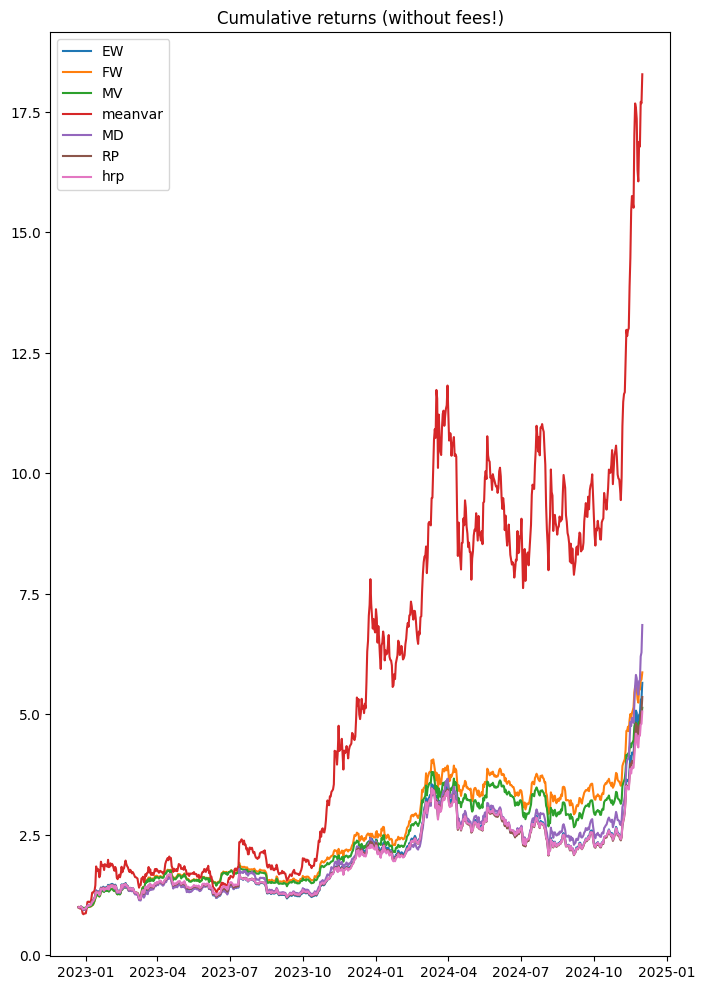

In [381]:
pf_ret = pf_ret.dropna()


plt.figure(figsize=(8, 12))
plt.plot((1+pf_ret['EW']).cumprod(), label='EW')
plt.plot((1+pf_ret['FW']).cumprod(), label='FW')
plt.plot((1+pf_ret['MV']).cumprod(), label='MV')
plt.plot((1+pf_ret['meanvar']).cumprod(), label='meanvar')
plt.plot((1+pf_ret['MD']).cumprod(), label='MD')
plt.plot((1+pf_ret['RP']).cumprod(), label='RP')
#plt.plot((1+pf_ret['mom']).cumprod(), label='mom')
#plt.plot((1+pf_ret['kms']).cumprod(), label='kms')
#plt.plot((1+pf_ret['kms_rebalanced']).cumprod(), label='kms_rebalanced')
plt.plot((1+pf_ret['hrp']).cumprod(), label='hrp')
plt.legend()
plt.title('Cumulative returns (without fees!)')
plt.show()

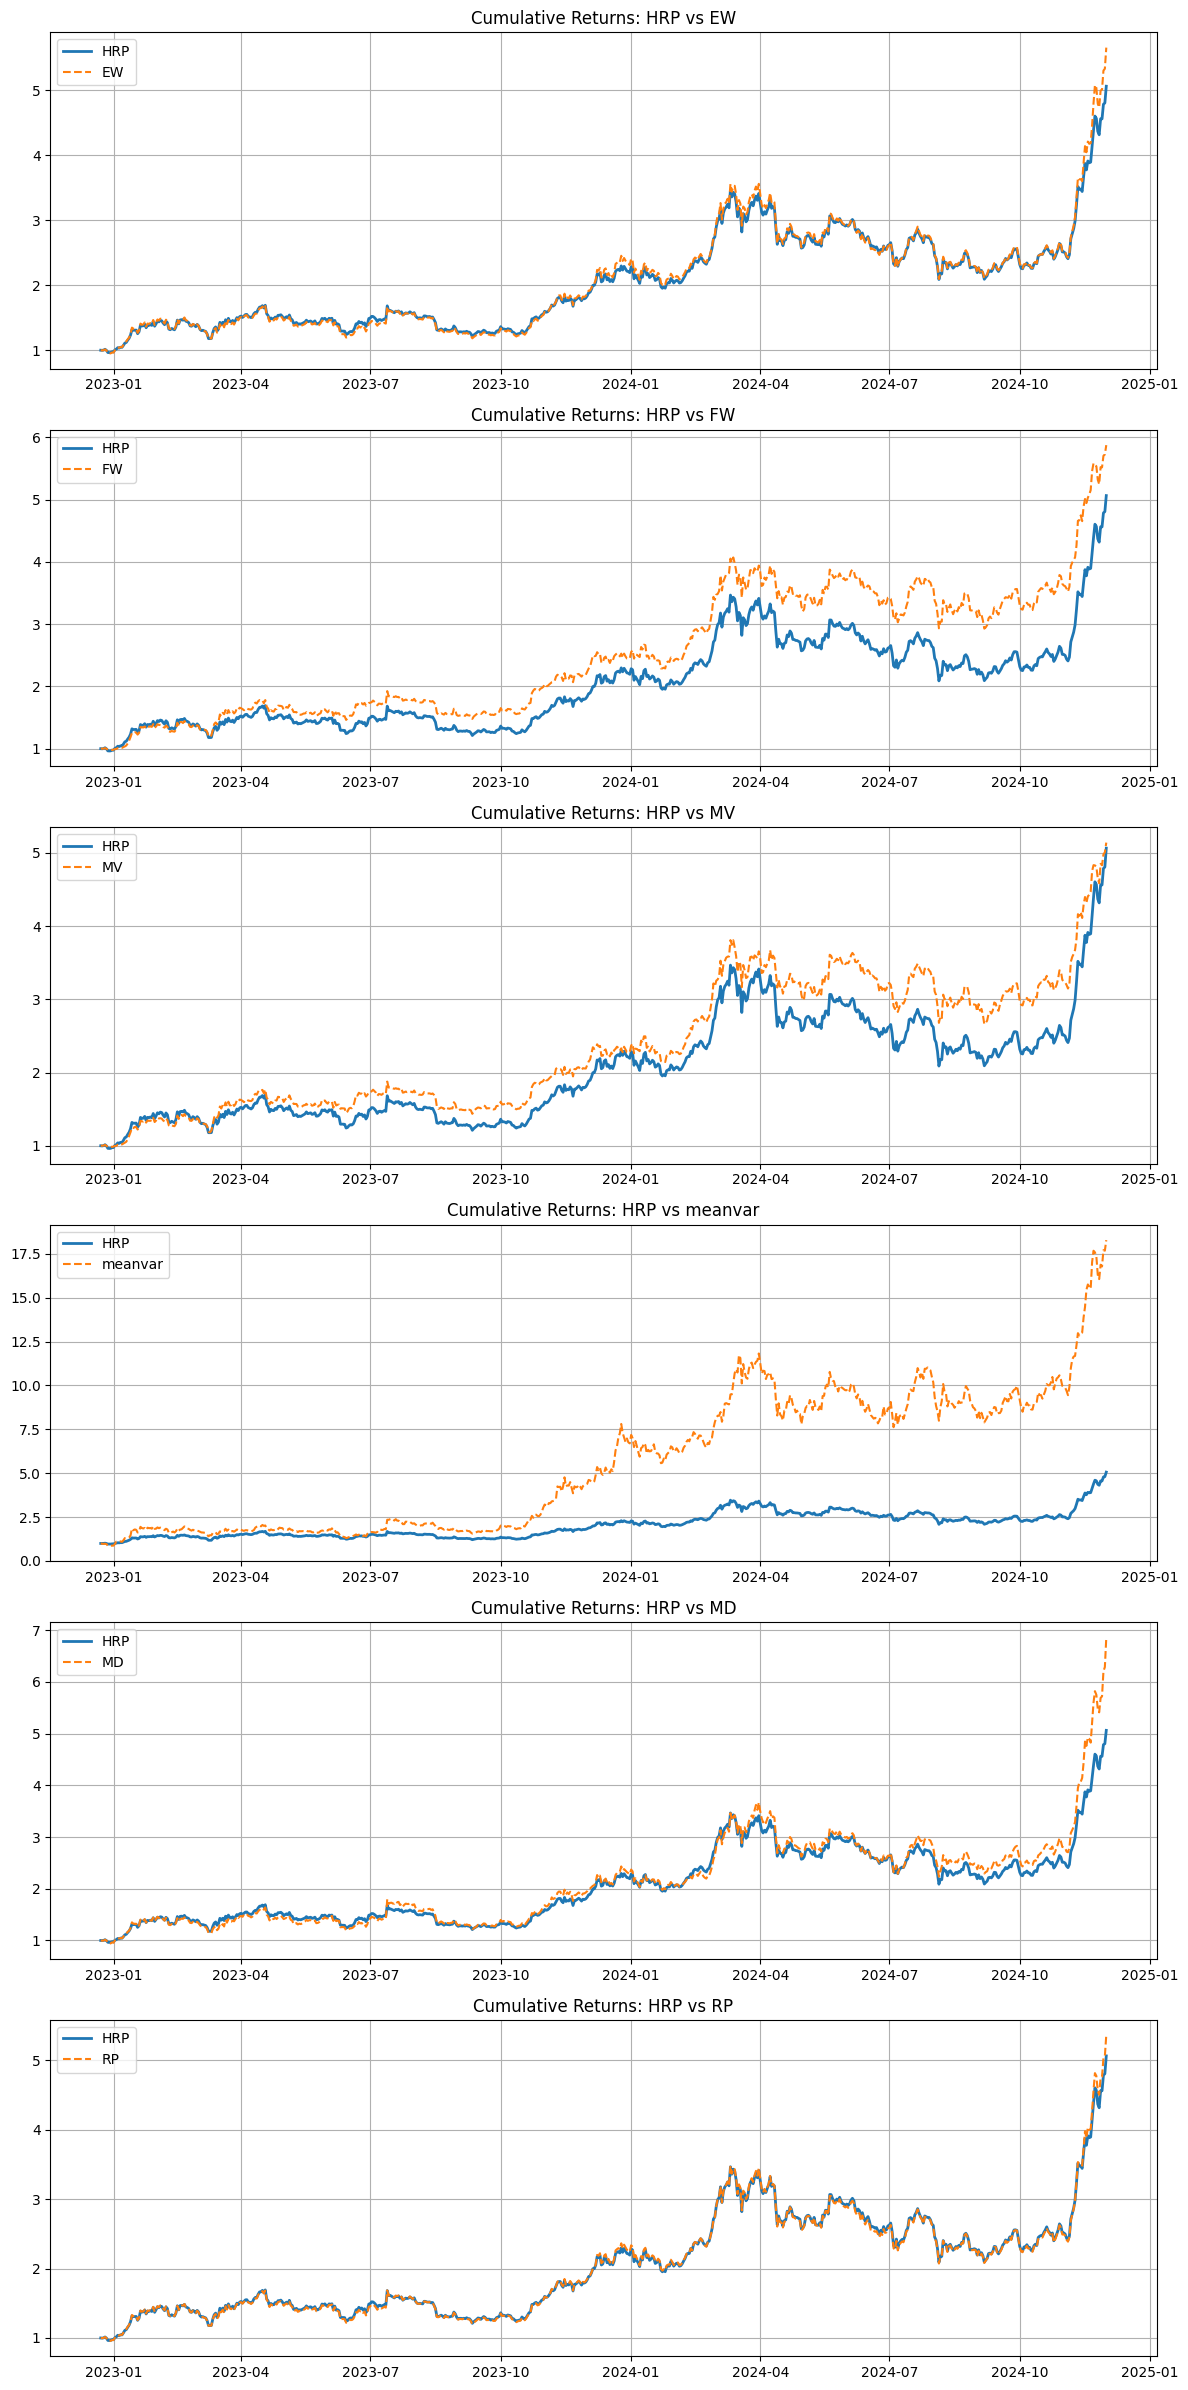

In [383]:
import matplotlib.pyplot as plt

# Drop missing values
pf_ret = pf_ret.dropna()

# List of all strategies
strategies = ['EW', 'FW', 'MV', 'meanvar', 'MD', 'RP','hrp']

# Pair HRP with each strategy (excluding HRP vs. HRP)
hrp_combinations = [strategy for strategy in strategies if strategy != 'hrp']

# Plot HRP combinations
plt.figure(figsize=(12, len(hrp_combinations) * 4))  # Adjust figure size based on number of plots

for i, strategy in enumerate(hrp_combinations, 1):
    plt.subplot(len(hrp_combinations), 1, i)
    plt.plot((1 + pf_ret['hrp']).cumprod(), label='HRP', linestyle='-', linewidth=2)
    plt.plot((1 + pf_ret[strategy]).cumprod(), label=strategy, linestyle='--')
    plt.legend()
    plt.title(f'Cumulative Returns: HRP vs {strategy}')
    plt.grid()

plt.tight_layout()
plt.show()


# Kurtosis Minimization Strategy (KMS)

Reference: [Analyzing Portfolio Optimization in Cryptocurrency Markets: A Comparative Study of Short-Term Investment Strategies Using Hourly Data Approach](https://www.mdpi.com/1911-8074/17/3/125)

Note: We tuned the strategy and applied KMS on daily data instead of hourly to match with existing strategies.

In [384]:
log_daily_returns = np.log(daily_data / daily_data.shift(1))
log_daily_returns = log_daily_returns[log_daily_returns.index >= '2022-12-22'][1:]
log_daily_returns.head()

,BTCUSD,ETHUSD,XRPUSD,ADAUSD,DOGEUSD,DOTUSD,LTCUSD,SOLUSD
date,,,,,,,,
2022-12-23,-0.002500,0.001887,0.013947,0.012141,-0.006222,-0.012436,-0.005609,0.003750
2022-12-24,0.003570,0.000164,-0.007048,-0.002548,0.011891,-0.005153,-0.000304,-0.033192
2022-12-25,-0.000653,-0.001968,-0.018492,0.001776,-0.019723,0.003811,0.050122,-0.000676
2022-12-26,0.005275,0.007850,0.057764,0.015847,-0.019852,0.023223,0.020897,-0.005238
2022-12-27,-0.012910,-0.013696,0.003299,-0.016195,-0.012509,-0.020319,-0.026844,-0.026032


In [385]:
# Calculate kurtosis for each asset
kurtosis = log_daily_returns.kurtosis()

# Calculate weights inversely proportional to kurtosis
weights = 1 / kurtosis
weights /= weights.sum()  # Normalize to sum to 1

print("Kurtosis:")
kurtosis

Kurtosis:


,0
BTCUSD,2.419166
ETHUSD,3.858861
XRPUSD,47.638180
ADAUSD,4.581326
DOGEUSD,4.256658
DOTUSD,4.411806
LTCUSD,5.776183
SOLUSD,2.834171


In [386]:
print("Portfolio Weights:")
weights

Portfolio Weights:


,0
BTCUSD,0.217638
ETHUSD,0.136440
XRPUSD,0.011052
ADAUSD,0.114923
DOGEUSD,0.123689
DOTUSD,0.119339
LTCUSD,0.091150
SOLUSD,0.185769


In [387]:
# Compute weighted returns for each asset
individual_weighted_returns = log_daily_returns.mul(weights, axis=1)

# Check individual contributions
print("Individual Asset Weighted Returns:")
individual_weighted_returns.head()

Individual Asset Weighted Returns:


,BTCUSD,ETHUSD,XRPUSD,ADAUSD,DOGEUSD,DOTUSD,LTCUSD,SOLUSD
date,,,,,,,,
2022-12-23,-0.000544,0.000257,0.000154,0.001395,-0.000770,-0.001484,-0.000511,0.000697
2022-12-24,0.000777,0.000022,-0.000078,-0.000293,0.001471,-0.000615,-0.000028,-0.006166
2022-12-25,-0.000142,-0.000269,-0.000204,0.000204,-0.002440,0.000455,0.004569,-0.000126
2022-12-26,0.001148,0.001071,0.000638,0.001821,-0.002456,0.002771,0.001905,-0.000973
2022-12-27,-0.002810,-0.001869,0.000036,-0.001861,-0.001547,-0.002425,-0.002447,-0.004836


In [389]:
# Adding KMS to pf_ret
pf_ret['kms'] = individual_weighted_returns.sum(axis = 1)

In [390]:
# annualized return and volatility
freq = 'daily'
if freq == 'monthly':
    ann_mean = ((1+pf_ret.mean()) ** 12) - 1
    ann_vol = pf_ret.std() * (12**0.5)
elif freq == 'daily':
    ann_mean = ((1+pf_ret.mean()) ** 365) - 1
    ann_vol = pf_ret.std() * (365**0.5)

# Sharpe ratio
sharpe_ratio = ann_mean / ann_vol

# maximum drawdown
cummulative_return = (1 + pf_ret).cumprod()
previous_peaks = cummulative_return.cummax()
drawdown = (previous_peaks - cummulative_return)/previous_peaks
max_drawdown = abs(drawdown.max())

summ_tab = pd.DataFrame(columns=['EW', 'FW', 'MV', 'meanvar', 'MD', 'RP','kms']) # mom
summ_tab.loc['Annualized return'] = ann_mean
summ_tab.loc['Annualized volatility'] = ann_vol
summ_tab.loc['Sharpe ratio'] = sharpe_ratio
summ_tab.loc['Max DD'] = max_drawdown

summ_tab

,EW,FW,MV,meanvar,MD,RP,kms
Annualized return,1.879068,1.790654,1.600459,5.156495,2.244936,1.773601,1.321079
Annualized volatility,0.580545,0.485211,0.481050,0.818669,0.618385,0.563009,0.575659
Sharpe ratio,3.236733,3.690465,3.327010,6.298629,3.630322,3.150218,2.294899
Max DD,0.411407,0.280709,0.301437,0.365268,0.391324,0.404256,0.480656


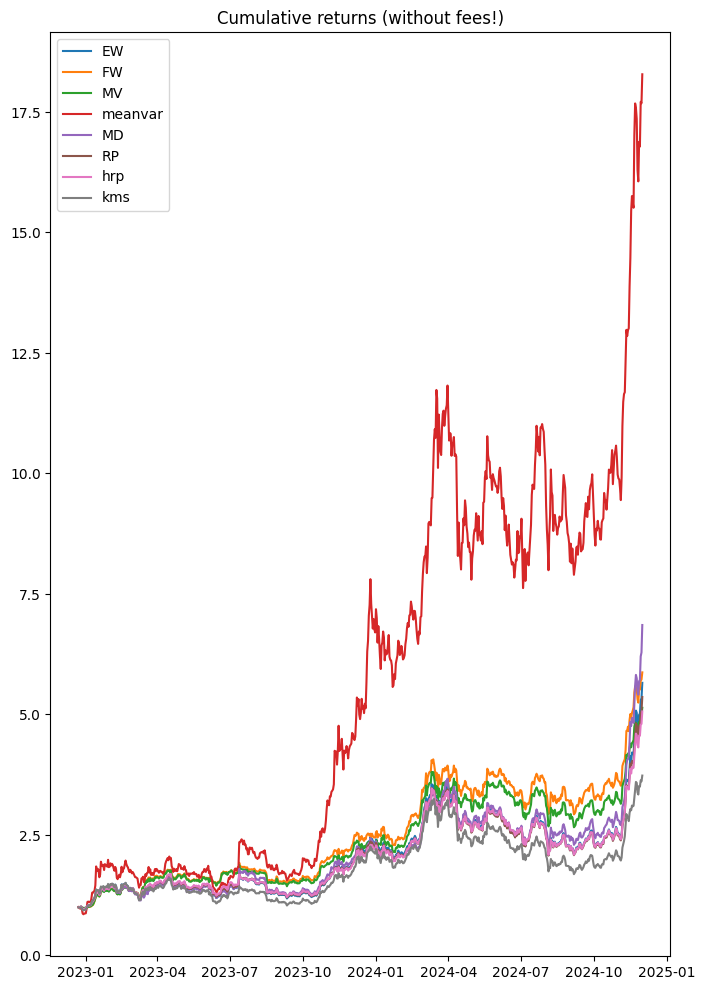

In [392]:
pf_ret = pf_ret.dropna()


plt.figure(figsize=(8, 12))
plt.plot((1+pf_ret['EW']).cumprod(), label='EW')
plt.plot((1+pf_ret['FW']).cumprod(), label='FW')
plt.plot((1+pf_ret['MV']).cumprod(), label='MV')
plt.plot((1+pf_ret['meanvar']).cumprod(), label='meanvar')
plt.plot((1+pf_ret['MD']).cumprod(), label='MD')
plt.plot((1+pf_ret['RP']).cumprod(), label='RP')
#plt.plot((1+pf_ret['mom']).cumprod(), label='mom')
plt.plot((1+pf_ret['hrp']).cumprod(), label='hrp')
plt.plot((1+pf_ret['kms']).cumprod(), label='kms')
plt.legend()
plt.title('Cumulative returns (without fees!)')
plt.show()

In [ ]:
# Define rebalancing period (e.g., weekly)
rebalancing_period = 70

# Initialize variables to store individual contributions
crypto_contributions = pd.DataFrame(index=daily_returns.index, columns=daily_returns.columns).fillna(0)

# Define sensitivity factors
sensitivity_factors = [0.9, 1.0, 1.1]
sensitivity_results = {}

for factor in sensitivity_factors:
    # Initialize DataFrame to store results for the current factor
    factor_contributions = pd.DataFrame(index=daily_returns.index, columns=daily_returns.columns).fillna(0)

    for i in range(0, len(daily_returns), rebalancing_period):
        # Subset data for the current period
        period_data = daily_returns.iloc[i:i + rebalancing_period]

        # Recalculate weights (adjusting the initial kurtosis by the factor)
        period_kurtosis = period_data.kurtosis()
        adjusted_kurtosis = period_kurtosis * factor  # Apply sensitivity factor only to baseline kurtosis
        period_weights = 1 / adjusted_kurtosis
        period_weights /= period_weights.sum()  # Normalize weights

        # Calculate individual contributions for the period
        for asset in daily_returns.columns:
            factor_contributions.loc[period_data.index, asset] = period_weights[asset] * period_data[asset]

    # Store results for the current factor
    sensitivity_results[f'Factor {factor}'] = {
        'Individual Contributions': factor_contributions,
        'Weights': period_weights
    }

In [434]:
# Adding KMS_rebalanced to pf_ret
pf_ret['kms_rebalanced'] = crypto_contributions.sum(axis = 1)

In [435]:
# annualized return and volatility
freq = 'daily'
if freq == 'monthly':
    ann_mean = ((1+pf_ret.mean()) ** 12) - 1
    ann_vol = pf_ret.std() * (12**0.5)
elif freq == 'daily':
    ann_mean = ((1+pf_ret.mean()) ** 365) - 1
    ann_vol = pf_ret.std() * (365**0.5)

# Sharpe ratio
sharpe_ratio = ann_mean / ann_vol

# maximum drawdown
cummulative_return = (1 + pf_ret).cumprod()
previous_peaks = cummulative_return.cummax()
drawdown = (previous_peaks - cummulative_return)/previous_peaks
max_drawdown = abs(drawdown.max())

summ_tab = pd.DataFrame(columns=['EW', 'FW', 'MV', 'meanvar', 'MD', 'RP','kms','kms_rebalanced'])
summ_tab.loc['Annualized return'] = ann_mean
summ_tab.loc['Annualized volatility'] = ann_vol
summ_tab.loc['Sharpe ratio'] = sharpe_ratio
summ_tab.loc['Max DD'] = max_drawdown

summ_tab

,EW,FW,MV,meanvar,MD,RP,kms,kms_rebalanced
Annualized return,1.879068,1.790654,1.600459,5.156495,2.244936,1.773601,1.321079,8.288798
Annualized volatility,0.580545,0.485211,0.481050,0.818669,0.618385,0.563009,0.575659,1.319353
Sharpe ratio,3.236733,3.690465,3.327010,6.298629,3.630322,3.150218,2.294899,6.282470
Max DD,0.411407,0.280709,0.301437,0.365268,0.391324,0.404256,0.480656,0.800570


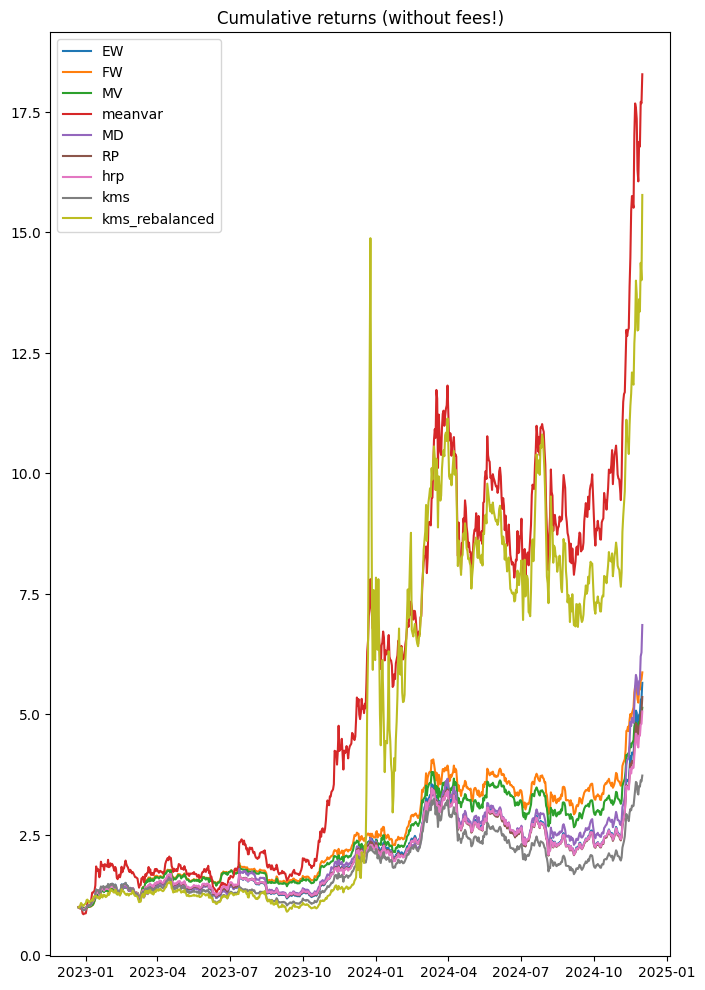

In [436]:
pf_ret = pf_ret.dropna()


plt.figure(figsize=(8, 12))
plt.plot((1+pf_ret['EW']).cumprod(), label='EW')
plt.plot((1+pf_ret['FW']).cumprod(), label='FW')
plt.plot((1+pf_ret['MV']).cumprod(), label='MV')
plt.plot((1+pf_ret['meanvar']).cumprod(), label='meanvar')
plt.plot((1+pf_ret['MD']).cumprod(), label='MD')
plt.plot((1+pf_ret['RP']).cumprod(), label='RP')
#plt.plot((1+pf_ret['mom']).cumprod(), label='mom')
plt.plot((1+pf_ret['hrp']).cumprod(), label='hrp')
plt.plot((1+pf_ret['kms']).cumprod(), label='kms')
plt.plot((1+pf_ret['kms_rebalanced']).cumprod(), label='kms_rebalanced')
plt.legend()
plt.title('Cumulative returns (without fees!)')
plt.show()

### Sensitivity Analysis for KMS Rebalanced

In [441]:
# Define rebalancing period (e.g., weekly)
rebalancing_period = 70

# Initialize variables to store individual contributions
crypto_contributions = pd.DataFrame(index=daily_returns.index, columns=daily_returns.columns).fillna(0)

# Define sensitivity factors i.e. -10%+
sensitivity_factors = [0.9, 1.1]
sensitivity_results = {}

for factor in sensitivity_factors:
    # Initialize DataFrame to store results for the current factor
    factor_contributions = pd.DataFrame(index=daily_returns.index, columns=daily_returns.columns).fillna(0)

    for i in range(0, len(daily_returns), rebalancing_period):
        # Subset data for the current period
        period_data = daily_returns.iloc[i:i + rebalancing_period]

        # Recalculate weights (adjusting the initial kurtosis by the factor)
        period_kurtosis = period_data.kurtosis()
        adjusted_kurtosis = period_kurtosis * factor
        period_weights = 1 / adjusted_kurtosis
        period_weights /= period_weights.sum()  # Normalize weights

        # Calculate individual contributions for the period
        for asset in daily_returns.columns:
            factor_contributions.loc[period_data.index, asset] = period_weights[asset] * period_data[asset]

    # Store results for the current factor
    sensitivity_results[f'Factor {factor}'] = {
        'Individual Contributions': factor_contributions,
        'Weights': period_weights
    }

    # Adding KMS_rebalanced to pf_ret
    pf_ret[f'kms_rebalanced_{factor}'] = factor_contributions.sum(axis = 1)

In [442]:
# annualized return and volatility
freq = 'daily'
if freq == 'monthly':
    ann_mean = ((1+pf_ret.mean()) ** 12) - 1
    ann_vol = pf_ret.std() * (12**0.5)
elif freq == 'daily':
    ann_mean = ((1+pf_ret.mean()) ** 365) - 1
    ann_vol = pf_ret.std() * (365**0.5)

# Sharpe ratio
sharpe_ratio = ann_mean / ann_vol

# maximum drawdown
cummulative_return = (1 + pf_ret).cumprod()
previous_peaks = cummulative_return.cummax()
drawdown = (previous_peaks - cummulative_return)/previous_peaks
max_drawdown = abs(drawdown.max())

summ_tab = pd.DataFrame(columns=['EW', 'FW', 'MV', 'meanvar', 'MD', 'RP','kms','kms_rebalanced','kms_rebalanced_0.9','kms_rebalanced_1.1'])
summ_tab.loc['Annualized return'] = ann_mean
summ_tab.loc['Annualized volatility'] = ann_vol
summ_tab.loc['Sharpe ratio'] = sharpe_ratio
summ_tab.loc['Max DD'] = max_drawdown

summ_tab

,EW,FW,MV,meanvar,MD,RP,kms,kms_rebalanced,kms_rebalanced_0.9,kms_rebalanced_1.1
Annualized return,1.879068,1.790654,1.600459,5.156495,2.244936,1.773601,1.321079,8.288798,8.288798,8.288798
Annualized volatility,0.580545,0.485211,0.481050,0.818669,0.618385,0.563009,0.575659,1.319353,1.319353,1.319353
Sharpe ratio,3.236733,3.690465,3.327010,6.298629,3.630322,3.150218,2.294899,6.282470,6.282470,6.282470
Max DD,0.411407,0.280709,0.301437,0.365268,0.391324,0.404256,0.480656,0.800570,0.800570,0.800570


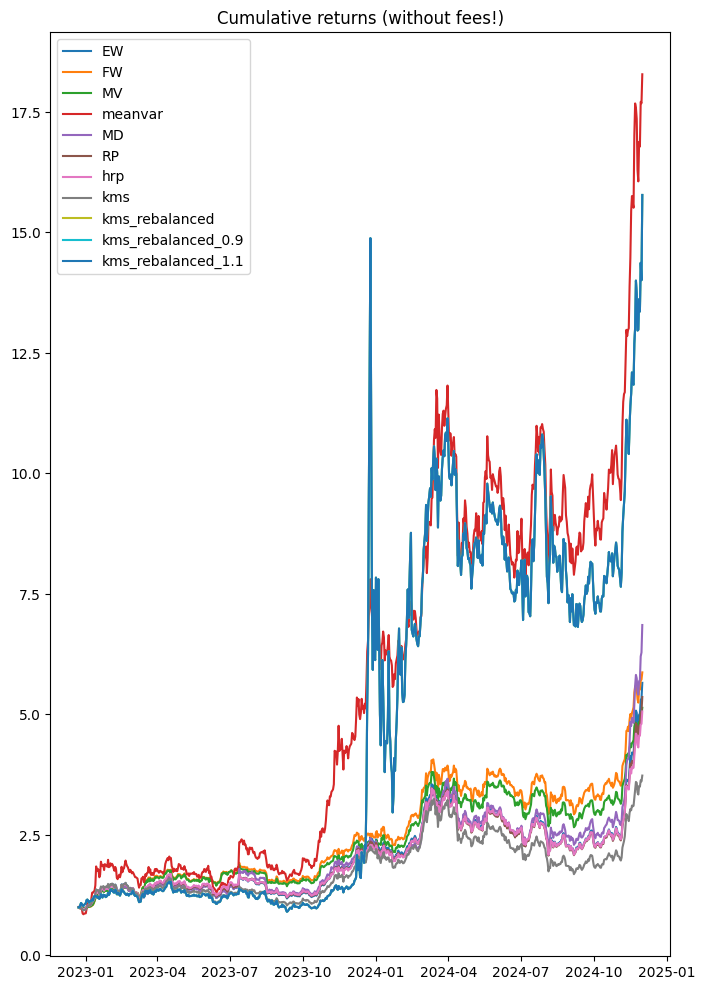

In [445]:
wpf_ret = pf_ret.dropna()


plt.figure(figsize=(8, 12))
plt.plot((1+pf_ret['EW']).cumprod(), label='EW')
plt.plot((1+pf_ret['FW']).cumprod(), label='FW')
plt.plot((1+pf_ret['MV']).cumprod(), label='MV')
plt.plot((1+pf_ret['meanvar']).cumprod(), label='meanvar')
plt.plot((1+pf_ret['MD']).cumprod(), label='MD')
plt.plot((1+pf_ret['RP']).cumprod(), label='RP')
#plt.plot((1+pf_ret['mom']).cumprod(), label='mom')
plt.plot((1+pf_ret['hrp']).cumprod(), label='hrp')
plt.plot((1+pf_ret['kms']).cumprod(), label='kms')
plt.plot((1+pf_ret['kms_rebalanced']).cumprod(), label='kms_rebalanced')
plt.plot((1+pf_ret['kms_rebalanced_0.9']).cumprod(), label='kms_rebalanced_0.9')
plt.plot((1+pf_ret['kms_rebalanced_1.1']).cumprod(), label='kms_rebalanced_1.1')
plt.legend()
plt.title('Cumulative returns (without fees!)')
plt.show()